In [8]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
    array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
from itertools import chain


In [9]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

sns.set_style("whitegrid")


In [10]:
# block function from pyblock package -  https://github.com/jsspencer/pyblock
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances
    # for each blocking transformation
    for i in arange(0, d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum((x[0:(n-1)]-mu)*(x[1:n]-mu))
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]

    # we need a list of magic numbers
    q = np.array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0, d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))


def free_energy_1D_blockerror(a, T, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(histo)
    # free_energy=-(0.001987*T)*np.log(histo)
    free_energy = -(0.001987*T)*np.log(histo+.000001)
    free_energy = free_energy-np.min(free_energy)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    ferr = -(0.001987*T)*(error / average)
    return free_energy, xcenters, ferr


def chunkIt(a, num):
    avg = a / float(num)
    out = []
    last = 0.0
    while last < a-1:
        out.append([int(last), int(last+avg)])
        last += avg
    return out


def histo_blockerror(a, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    return average, xcenters, error


def Kd_calc(bound, conc):
    return((1-bound)*conc/bound)


def get_blockerrors(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        be = block(data)**.5
        ave.append(np.average(data))
        block_errors.append(be)
    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac

    return ave_bf, be_bf


def get_blockerrors_pyblock(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)
            opt = pyblock.blocking.find_optimal_block(
                len(data), reblock_data)[0]
            if type(opt) != int: 
                opt = 10
            opt_block = reblock_data[opt]
            be = opt_block[4]
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)

    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac
    return ave_bf, be_bf


def get_blockerror(Data):
    data = Data
    average = np.average(data)
    be = block(data)**.5
    return average, be


def get_blockerror_pyblock(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        print(opt)
        be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)


def get_blockerror_pyblock_nanskip(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        if(math.isnan(opt)):
            be_max = 0
            for i in range(0, len(reblock_data)):
                be = reblock_data[i][4]
                if(be > be_max):
                    be_max = be
        else:
            be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)


In [11]:
def calc_SA(trj, helix, start, stop):
    r0 = .10
    RMS_start = start
    RMS_stop = stop
    RMS = []
    for i in range(RMS_start, RMS_stop):
        sel = helix.topology.select("residue %s to %s and name CA" % (i, i+6))
        rmsd = md.rmsd(trj, helix, atom_indices=sel)
        RMS.append(rmsd)
    RMS = np.asarray(RMS)
    Sa_sum = np.zeros((trj.n_frames))
    Sa = (1.0-(RMS/0.10)**8)/(1-(RMS/0.10)**12)
    return Sa


def calc_Rg(trj):
    mass = []
    for at in trj.topology.atoms:
        mass.append(at.element.mass)
    mass_CA = len(mass)*[0.0]
    for i in trj.topology.select("name CA"):
        mass_CA[i] = 1.0
    rg_CA = md.compute_rg(trj, masses=np.array(mass_CA))
    return rg_CA


def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


def free_energy_reweight(a, b, T, y0, ymax, x0, xmax, weight):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=weight)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


def free_energy_1D_noscale(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    free_energy = np.log(free_energy+.000001)
    free_energy = -(0.001987*T)*free_energy
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def free_energy_1D(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(free_energy)
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*(free_energy-np.log(max+.0000001))
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def free_energy_1D_reweight(a, T, x0, xmax, bins, weight):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=weight)
    max = np.max(free_energy)
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*(free_energy-np.log(max+.0000001))
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def alphabeta_rmsd(phi, psi, phi_ref, psi_ref):
    alphabetarmsd = np.sum(0.5*(1+np.cos(psi-psi_ref)),
                           axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)), axis=1)
    return alphabetarmsd


def dssp_convert(dssp):
    dsspH = np.copy(dssp)
    dsspE = np.copy(dssp)
    dsspH[dsspH == 'H'] = 1
    dsspH[dsspH == 'E'] = 0
    dsspH[dsspH == 'C'] = 0
    dsspH[dsspH == 'NA'] = 0
    dsspH = dsspH.astype(int)
    TotalH = np.sum(dsspH, axis=1)
    SE_H = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspH[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_H[i] = [np.mean(data), (block(data))**.5]

    dsspE[dsspE == 'H'] = 0
    dsspE[dsspE == 'E'] = 1
    dsspE[dsspE == 'C'] = 0
    dsspE[dsspE == 'NA'] = 0
    dsspE = dsspE.astype(int)
    TotalE = np.sum(dsspE, axis=1)
    Eprop = np.sum(dsspE, axis=0).astype(float)/len(dsspE)
    SE_E = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspE[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_E[i] = [np.mean(data), (block(data))**.5]
    return SE_H, SE_E


def calc_phipsi(trj):
    indices_phi, phis = md.compute_phi(trj)
    indices_psi, psis = md.compute_psi(trj)
    phi_label = []
    for i_phi in range(0, indices_phi.shape[0]):
        resindex = trj.topology.atom(indices_phi[i_phi][2]).residue.resSeq
        phi_label.append(resindex)
    phi_label = np.array(phi_label)
    psi_label = []
    for i_psi in range(0, indices_psi.shape[0]):
        resindex = trj.topology.atom(indices_psi[i_psi][2]).residue.resSeq
        psi_label.append(resindex)
    psi_label = np.array(psi_label)
    phipsi = []
    for i in range(0, len(phi_label)-1):
        current_phipsi = np.column_stack((phis[:, i+1], psis[:, i]))
        phipsi.append(current_phipsi)
    phipsi_array = np.array(phipsi)
    return(phipsi_array, psi_label, phi_label)


In [12]:
# Functions to Calculate Aromatic Stacking Interactions
from __future__ import print_function, division
from mdtraj.geometry import _geometry
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles


def find_plane_normal(points):

    N = points.shape[0]
    A = np.concatenate((points[:, 0:2], np.ones((N, 1))), axis=1)
    B = points[:, 2]
    out = lstsq(A, B, rcond=-1)
    na_c, nb_c, d_c = out[0]
    if d_c != 0.0:
        cu = 1./d_c
        bu = -nb_c*cu
        au = -na_c*cu
    else:
        cu = 1.0
        bu = -nb_c
        au = -na_c
    normal = np.asarray([au, bu, cu])
    normal /= math.sqrt(dot(normal, normal))
    return normal


def find_plane_normal2(positions):
    # Alternate approach used to check sign - could the sign check cause descrepency with desres?
    # Use Ligand IDs 312, 308 and 309 to check direction
    # [304 305 306 307 308 309 310 311 312 313]
    v1 = positions[0]-positions[1]
    v1 /= np.sqrt(np.sum(v1**2))
    v2 = positions[2]-positions[1]
    v2 /= np.sqrt(np.sum(v2**2))
    normal = np.cross(v1, v2)
    return normal


def find_plane_normal2_assign_atomid(positions, id1, id2, id3):
    # Alternate approach used to check sign - could the sign check cause descrepency with desres?
    v1 = positions[id1]-positions[id2]
    v1 /= np.sqrt(np.sum(v1**2))
    v2 = positions[id3]-positions[id1]
    v2 /= np.sqrt(np.sum(v2**2))
    normal = np.cross(v1, v2)
    return normal


def get_ring_center_normal_assign_atomid(positions, id1, id2, id3):
    center = np.mean(positions, axis=0)
    normal = find_plane_normal(positions)
    normal2 = find_plane_normal2_assign_atomid(positions, id1, id2, id3)
    # check direction of normal using dot product convention
    comp = np.dot(normal, normal2)
    if comp < 0:
        normal = -normal
    return center, normal


def get_ring_center_normal_(positions):
    center = np.mean(positions, axis=0)
    normal = find_plane_normal(positions)
    normal2 = find_plane_normal2(positions)
    # check direction of normal using dot product convention
    comp = np.dot(normal, normal2)
    if comp < 0:
        normal = -normal
    return center, normal


def angle(v1, v2):
    return np.arccos(np.dot(v1, v2)/(np.sqrt(np.dot(v1, v1))*np.sqrt(np.dot(v2, v2))))


def get_ring_center_normal_trj_assign_atomid(position_array, id1, id2, id3):
    length = len(position_array)
    centers = np.zeros((length, 3))
    normals = np.zeros((length, 3))
    centers_normals = np.zeros((length, 2, 3))
    print(np.shape(length), np.shape(centers), np.shape(normals))
    for i in range(0, len(position_array)):
        center, normal = get_ring_center_normal_assign_atomid(
            position_array[i], id1, id2, id3)
        centers_normals[i][0] = center
        centers_normals[i][1] = normal
    return centers_normals

# MDtraj Functions to Calculate Hydrogen Bonds with custom selections of donors and acceptors

def _get_bond_triplets_print(topology, lig_donors, exclude_water=True, sidechain_only=False):
    def can_participate(atom):
        # Filter waters
        if exclude_water and atom.residue.is_water:
            return False
        # Filter non-sidechain atoms
        if sidechain_only and not atom.is_sidechain:
            return False
        # Otherwise, accept it
        return True

    def get_donors(e0, e1):
        # Find all matching bonds
        # print("get_donors e0 e1:",e0,e1)
        elems = set((e0, e1))
        atoms = [(one, two) for one, two in topology.bonds
                 if set((one.element.symbol, two.element.symbol)) == elems]
        # Filter non-participating atoms
        atoms = [atom for atom in atoms
                 if can_participate(atom[0]) and can_participate(atom[1])]
        # Get indices for the remaining atoms
        indices = []
        for a0, a1 in atoms:
            pair = (a0.index, a1.index)
            # make sure to get the pair in the right order, so that the index
            # for e0 comes before e1
            if a0.element.symbol == e1:
                pair = pair[::-1]
            indices.append(pair)

        return indices

    # Check that there are bonds in topology
    nbonds = 0
    for _bond in topology.bonds:
        nbonds += 1
        break  # Only need to find one hit for this check (not robust)
    if nbonds == 0:
        raise ValueError('No bonds found in topology. Try using '
                         'traj._topology.create_standard_bonds() to create bonds '
                         'using our PDB standard bond definitions.')

    nh_donors = get_donors('N', 'H')
    print("nh_donors", nh_donors)
    for i in nh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    oh_donors = get_donors('O', 'H')
    print("oh_donors", oh_donors)
    for i in oh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    sh_donors = get_donors('S', 'H')
    print("sh_donors", sh_donors)
    for i in sh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    for i in lig_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    # ADD IN ADDITIONAL SPECIFIED LIGAND DONORS
    xh_donors = np.array(nh_donors + oh_donors + sh_donors+lig_donors)

    if len(xh_donors) == 0:
        # if there are no hydrogens or protein in the trajectory, we get
        # no possible pairs and return nothing
        return np.zeros((0, 3), dtype=int)

    acceptor_elements = frozenset(('O', 'N', 'S'))
    acceptors = [a.index for a in topology.atoms
                 if a.element.symbol in acceptor_elements and can_participate(a)]
    print("acceptors")
    for i in acceptors:
        print(top.atom(i))
    # Make acceptors a 2-D numpy array
    acceptors = np.array(acceptors)[:, np.newaxis]

    # Generate the cartesian product of the donors and acceptors
    xh_donors_repeated = np.repeat(xh_donors, acceptors.shape[0], axis=0)
    acceptors_tiled = np.tile(acceptors, (xh_donors.shape[0], 1))
    bond_triplets = np.hstack((xh_donors_repeated, acceptors_tiled))

    # Filter out self-bonds
    self_bond_mask = (bond_triplets[:, 0] == bond_triplets[:, 2])
    return bond_triplets[np.logical_not(self_bond_mask), :]


def _get_bond_triplets(topology, lig_donors, exclude_water=True, sidechain_only=False):
    def can_participate(atom):
        # Filter waters
        if exclude_water and atom.residue.is_water:
            return False
        # Filter non-sidechain atoms
        if sidechain_only and not atom.is_sidechain:
            return False
        # Otherwise, accept it
        return True

    def get_donors(e0, e1):
        # Find all matching bonds
        elems = set((e0, e1))
        atoms = [(one, two) for one, two in topology.bonds
                 if set((one.element.symbol, two.element.symbol)) == elems]
        # Filter non-participating atoms
        atoms = [atom for atom in atoms
                 if can_participate(atom[0]) and can_participate(atom[1])]
        # Get indices for the remaining atoms
        indices = []
        for a0, a1 in atoms:
            pair = (a0.index, a1.index)
            # make sure to get the pair in the right order, so that the index
            # for e0 comes before e1
            if a0.element.symbol == e1:
                pair = pair[::-1]
            indices.append(pair)

        return indices

    # Check that there are bonds in topology
    nbonds = 0
    for _bond in topology.bonds:
        nbonds += 1
        break  # Only need to find one hit for this check (not robust)
    if nbonds == 0:
        raise ValueError('No bonds found in topology. Try using '
                         'traj._topology.create_standard_bonds() to create bonds '
                         'using our PDB standard bond definitions.')

    nh_donors = get_donors('N', 'H')
    oh_donors = get_donors('O', 'H')
    sh_donors = get_donors('S', 'H')
    xh_donors = np.array(nh_donors + oh_donors + sh_donors+lig_donors)

    if len(xh_donors) == 0:
        # if there are no hydrogens or protein in the trajectory, we get
        # no possible pairs and return nothing
        return np.zeros((0, 3), dtype=int)

    acceptor_elements = frozenset(('O', 'N', 'S'))
    acceptors = [a.index for a in topology.atoms
                 if a.element.symbol in acceptor_elements and can_participate(a)]
    # Make acceptors a 2-D numpy array
    acceptors = np.array(acceptors)[:, np.newaxis]

    # Generate the cartesian product of the donors and acceptors
    xh_donors_repeated = np.repeat(xh_donors, acceptors.shape[0], axis=0)
    acceptors_tiled = np.tile(acceptors, (xh_donors.shape[0], 1))
    bond_triplets = np.hstack((xh_donors_repeated, acceptors_tiled))

    # Filter out self-bonds
    self_bond_mask = (bond_triplets[:, 0] == bond_triplets[:, 2])
    return bond_triplets[np.logical_not(self_bond_mask), :]


def _compute_bounded_geometry(traj, triplets, distance_cutoff, distance_indices,
                              angle_indices, freq=0.0, periodic=True):
    """
    Returns a tuple include (1) the mask for triplets that fulfill the distance
    criteria frequently enough, (2) the actual distances calculated, and (3) the
    angles between the triplets specified by angle_indices.
    """
    # First we calculate the requested distances
    distances = md.compute_distances(
        traj, triplets[:, distance_indices], periodic=periodic)

    # Now we discover which triplets meet the distance cutoff often enough
    prevalence = np.mean(distances < distance_cutoff, axis=0)
    mask = prevalence > freq

    # Update data structures to ignore anything that isn't possible anymore
    triplets = triplets.compress(mask, axis=0)
    distances = distances.compress(mask, axis=1)

    # Calculate angles using the law of cosines
    abc_pairs = zip(angle_indices, angle_indices[1:] + angle_indices[:1])
    abc_distances = []

    # Calculate distances (if necessary)
    for abc_pair in abc_pairs:
        if set(abc_pair) == set(distance_indices):
            abc_distances.append(distances)
        else:
            abc_distances.append(md.compute_distances(traj, triplets[:, abc_pair],
                                                      periodic=periodic))

    # Law of cosines calculation
    a, b, c = abc_distances
    cosines = (a ** 2 + b ** 2 - c ** 2) / (2 * a * b)
    np.clip(cosines, -1, 1, out=cosines)  # avoid NaN error
    angles = np.arccos(cosines)
    return mask, distances, angles


def baker_hubbard2(traj, freq=0.1, exclude_water=True, periodic=True, sidechain_only=False,
                   distance_cutoff=0.35, angle_cutoff=150, lig_donor_index=[]):

    angle_cutoff = np.radians(angle_cutoff)

    if traj.topology is None:
        raise ValueError('baker_hubbard requires that traj contain topology '
                         'information')

    # Get the possible donor-hydrogen...acceptor triplets

    # ADD IN LIGAND HBOND DONORS
    add_donors = lig_donor_index

    bond_triplets = _get_bond_triplets(traj.topology,
                                       exclude_water=exclude_water, lig_donors=add_donors, sidechain_only=sidechain_only)

    mask, distances, angles = _compute_bounded_geometry(traj, bond_triplets,
                                                        distance_cutoff, [1, 2], [0, 1, 2], freq=freq, periodic=periodic)

    # Find triplets that meet the criteria
    presence = np.logical_and(
        distances < distance_cutoff, angles > angle_cutoff)
    mask[mask] = np.mean(presence, axis=0) > freq
    return bond_triplets.compress(mask, axis=0)


def print_donors_acceptors(traj, freq=0.1, exclude_water=True, periodic=True, sidechain_only=False,
                           distance_cutoff=0.35, angle_cutoff=150, lig_donor_index=[]):

    angle_cutoff = np.radians(angle_cutoff)

    if traj.topology is None:
        raise ValueError('baker_hubbard requires that traj contain topology '
                         'information')

    # Get the possible donor-hydrogen...acceptor triplets

    # ADD IN LIGAND HBOND DONORS
    # add_donors=[[296,318],[296,331]]
    # Manually tell it where to find proton donors on ligand
    # LIG58-O5 LIG58-H24
    # LIG58-O1 LIG58-H12
    # LIG58-N LIG58-H15
    # add_donors=[[768,796],[750,784],[752,787]]
    add_donors = lig_donor_index

    bond_triplets_print = _get_bond_triplets_print(traj.topology,
                                                   exclude_water=exclude_water, lig_donors=add_donors, sidechain_only=sidechain_only)

    # mask, distances, angles = _compute_bounded_geometry(traj, bond_triplets,
    #    distance_cutoff, [1, 2], [0, 1, 2], freq=freq, periodic=periodic)

    # Find triplets that meet the criteria
    # presence = np.logical_and(distances < distance_cutoff, angles > angle_cutoff)
    # mask[mask] = np.mean(presence, axis=0) > freq
    return


In [13]:
outdir = './outdir_s20g_hiapp_yxa1/'
!mkdir $outdir
pdb = '../structure_files/hiapp_s20g_yxa1.gro'
rep0 = "/Users/f006j60/Robustelli_Group/IAPP/s20g_yxa1/pbc_trj_2.82us/pbc_1.xtc"
helixpdb = '../structure_files/helix_s20g.pdb'
apodir = '../hiapp_s20g_apo/outdir_s20g_hiapp_apo/'


# Define Aromatic Rings in YXA1
ligand_rings = [[560,561,562,563,564,565], [553,554,555,556,557,558], [544,545,546,547,548,549]]
# Definie Hydrogen Bond Donors in YXA1
lig_hbond_donors = [[541,577],[552,583]]

# Simulation Length in microseconds
print("outdir:", outdir)
print("pdb:", pdb)
print("helix pdb:", helixpdb)
print("trjaectory:", rep0)


mkdir: ./outdir_s20g_hiapp_yxa1/: File exists
outdir: ./outdir_s20g_hiapp_yxa1/
pdb: ../structure_files/hiapp_s20g_yxa1.gro
helix pdb: ../structure_files/helix_s20g.pdb
trjaectory: /Users/f006j60/Robustelli_Group/IAPP/s20g_yxa1/pbc_trj_2.82us/pbc_1.xtc


In [14]:
trj = md.load(rep0, top=pdb, stride=1)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames = trj.n_frames
sim_length = trj.time/1000*80/1000
sim_length = sim_length[-1]

In [15]:
nres = []
for res in trj.topology.residues:
    nres.append(res.resSeq)
sequence = (' %s' % [residue for residue in trj.topology.residues])
resname = (' %s' % [residue.name for residue in trj.topology.residues])
resindex = (' %s' % [residue.index for residue in trj.topology.residues])
prot_top = top.subset(top.select('protein'))
prot_res = []
for res in prot_top.residues:
    prot_res.append(res.resSeq)
prot_resname = (' %s' % [residue.name for residue in prot_top.residues])
residues = len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

residues = 38
residue_offset = 1
prot_res_renum = np.asarray(prot_res)
print(prot_res_renum)
residue_number = range(0, residues)
residue_number_offsetres = range(residue_offset, residue_offset+residues)
print("Residue Number Range:", residue_number)


** SYSTEM INFO **

Number of atoms: 593

Number of residues: 39

Number of protein residues: 37

Number of frames: 35251

Starting frame: 0

Last frame: 35251

sequence:  [LYS1, CYS2, ASN3, THR4, ALA5, THR6, CYS7, ALA8, THR9, GLN10, ARG11, LEU12, ALA13, ASN14, PHE15, LEU16, VAL17, HIS18, SER19, GLY20, ASN21, ASN22, PHE23, GLY24, ALA25, ILE26, LEU27, SER28, SER29, THR30, ASN31, VAL32, GLY33, SER34, ASN35, THR36, TYR37, NH238, LIG39]

residue names:  ['LYS', 'CYS', 'ASN', 'THR', 'ALA', 'THR', 'CYS', 'ALA', 'THR', 'GLN', 'ARG', 'LEU', 'ALA', 'ASN', 'PHE', 'LEU', 'VAL', 'HIS', 'SER', 'GLY', 'ASN', 'ASN', 'PHE', 'GLY', 'ALA', 'ILE', 'LEU', 'SER', 'SER', 'THR', 'ASN', 'VAL', 'GLY', 'SER', 'ASN', 'THR', 'TYR', 'NH2', 'LIG']

residue index:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 3

In [16]:
print(residue_number_offsetres)

range(1, 39)


/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_95193/4034944248.py:23: RuntimeWarning: invalid value encountered in divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


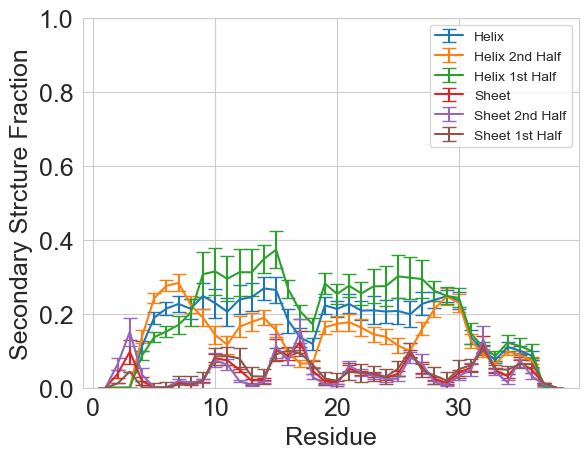

In [17]:
trjH1 = md.load(rep0, top=pdb, stride=1)
H1 = top.select("resid 0 to 37")
trjH1.restrict_atoms(H1)
trjH1.center_coordinates()
frames = trjH1.n_frames
half = int(np.floor(frames/2))

h_res = []
for res in trjH1.topology.residues:
    h_res.append(res.resSeq)
h_residues = len(set(h_res))
hres_renum = np.asarray(h_res)


frames = trj.n_frames
half = int(np.floor(frames/2))

dsspH1 = md.compute_dssp(trjH1, simplified=True)
dsspH1_h2 = md.compute_dssp(trjH1[half:-1], simplified=True)
dsspH1_h1 = md.compute_dssp(trjH1[0:half], simplified=True)

H1_H, H1_E = dssp_convert(dsspH1)
H1_H_h2, H1_E_h2 = dssp_convert(dsspH1_h2)
H1_H_h1, H1_E_h1 = dssp_convert(dsspH1_h1)

plt.errorbar(hres_renum, H1_H[:, 0], yerr=H1_H[:, 1], capsize=5, label='Helix')
plt.errorbar(
    hres_renum, H1_H_h2[:, 0], yerr=H1_H_h2[:, 1], capsize=5, label='Helix 2nd Half')
plt.errorbar(
    hres_renum, H1_H_h1[:, 0], yerr=H1_H_h1[:, 1], capsize=5, label='Helix 1st Half')
plt.errorbar(hres_renum, H1_E[:, 0], yerr=H1_E[:, 1], capsize=5, label='Sheet')
plt.errorbar(
    hres_renum, H1_E_h1[:, 0], yerr=H1_E_h1[:, 1], capsize=5, label='Sheet 2nd Half')
plt.errorbar(
    hres_renum, H1_E_h2[:, 0], yerr=H1_H_h2[:, 1], capsize=5, label='Sheet 1st Half')

plt.ylim(0, 1.0)
plt.legend(loc="upper right")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
np.savetxt(outdir+'Hprop.err.dat',
           np.column_stack((hres_renum, H1_H[:, 0], H1_H[:, 1])))
np.savetxt(outdir+'Eprop.err.dat',
           np.column_stack((hres_renum, H1_E[:, 0], H1_E[:, 1])))


(0.0, 1.0)

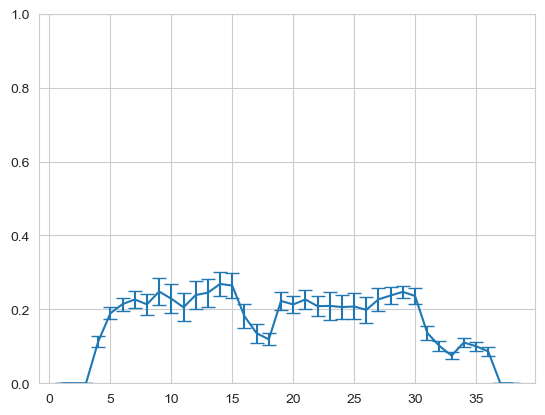

In [18]:
plt.errorbar(hres_renum, H1_H[:, 0], yerr=H1_H[:, 1], capsize=5, label='Helix')
plt.ylim(0,1.)

(0.0, 1.0)

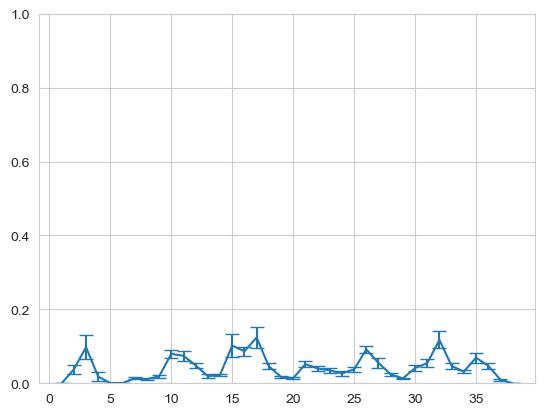

In [19]:
plt.errorbar(hres_renum, H1_E[:, 0], yerr=H1_E[:, 1], capsize=5, label='Sheet')
plt.ylim(0,1.)

In [20]:
hres_renum

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38])

In [21]:
dsspH = np.copy(dsspH1)
dsspH[dsspH == 'H'] = 1
dsspH[dsspH == 'E'] = 0
dsspH[dsspH == 'C'] = 0
dsspH[dsspH == 'NA'] = 0
dsspH = dsspH.astype(int)
TotalH = np.sum(dsspH, axis=1)
np.shape(dsspH1)
TotalH

print("Values for All Frames - Not Partitioned into Bound and Unbound")
print("Average Helical Residues:%6.3lf" %
      (np.average(TotalH)), "+_%6.3lf" % ((block(TotalH)**.5)))
print("Average Fraction Helix:%6.3lf" %
      (np.average(TotalH)/37.0), "+_%6.3lf" % ((block(TotalH)**.5)/37.0))


Values for All Frames - Not Partitioned into Bound and Unbound
Average Helical Residues: 6.343 +_ 0.615
Average Fraction Helix: 0.171 +_ 0.017


In [22]:
# Compute Phi and Psi
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
phi_label = []
for i_phi in range(0, indices_phi.shape[0]):
    resindex = trj.topology.atom(indices_phi[i_phi][3]).residue.resSeq
    phi_label.append(resindex)
phi_label = np.array(phi_label)
psi_label = []
for i_psi in range(0, indices_psi.shape[0]):
    resindex = trj.topology.atom(indices_psi[i_psi][3]).residue.resSeq
    psi_label.append(resindex)
psi_label = np.array(psi_label)
phipsi = []
for i in range(0, len(psi_label)-2):
    current_phipsi = np.column_stack((phis[:, i+1], psis[:, i]))
    phipsi.append(current_phipsi)
phipsi_array = np.array(phipsi)


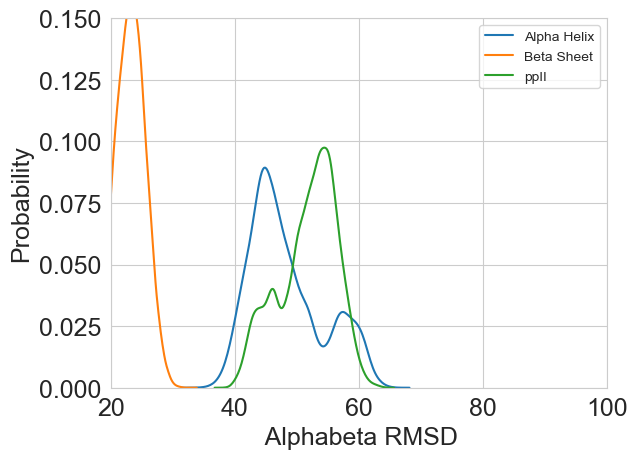

<Figure size 640x480 with 0 Axes>

In [23]:
def alphabeta_rmsd(phi, psi, phi_ref, psi_ref):
    alphabetarmsd = np.sum(0.5*(1+np.cos(psi-psi_ref)),
                           axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)), axis=1)
    return alphabetarmsd


Phi_all = phis
Psi_all = psis
alphabeta_alpharight = alphabeta_rmsd(Phi_all, Psi_all, -1.05, -0.79)
alphabeta_betasheet = alphabeta_rmsd(Phi_all, Psi_all, 2.36, -2.36)
alphabeta_ppII = alphabeta_rmsd(Phi_all, Psi_all, -1.31, 2.71)

sns.kdeplot(data=alphabeta_alpharight, label='Alpha Helix')
sns.kdeplot(data=alphabeta_betasheet, label='Beta Sheet')
sns.kdeplot(data=alphabeta_ppII, label='ppII')

plt.xlabel(' Alphabeta RMSD', fontsize=18)
plt.xlim(20, 100)
plt.ylim(0, 0.15)

plt.ylabel('Probability', fontsize=18)
plt.legend(loc='upper right')
plt.tick_params(labelsize=18)

plt.show()
plt.savefig(outdir+'Alphabeta.histogram.png')


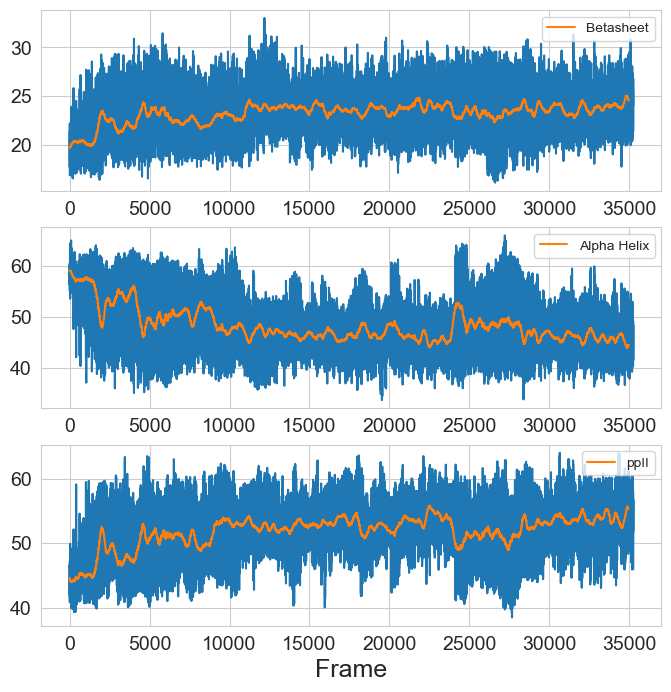

In [24]:
fig, ax = plt.subplots(3, figsize=((8, 8)))
N = 300
ax[0].plot(alphabeta_betasheet)
ax[0].plot(np.convolve(alphabeta_betasheet, np.ones(
    N)/N, mode='valid'), label='Betasheet')
ax[0].legend(loc='upper right')

ax[1].plot(alphabeta_alpharight)
ax[1].plot(np.convolve(alphabeta_alpharight, np.ones(
    N)/N, mode='valid'), label='Alpha Helix')
ax[1].legend(loc='upper right')

ax[2].plot(alphabeta_ppII)
ax[2].plot(np.convolve(alphabeta_ppII, np.ones(
    N)/N, mode='valid'), label='ppII')
ax[2].legend(loc='upper right')

ax[0].tick_params(labelsize=14)
ax[1].tick_params(labelsize=14)
ax[2].tick_params(labelsize=14)

plt.xlabel('Frame', size=18)
plt.savefig(outdir+'Alphabeta.timecourse.png')


CA Radius of Gyration: 1.236 +_ 0.019
1st Half CA Radius of Gyration: 1.172 +_ 0.007
2nd Half CA Radius of Gyration: 1.300 +_ 0.013


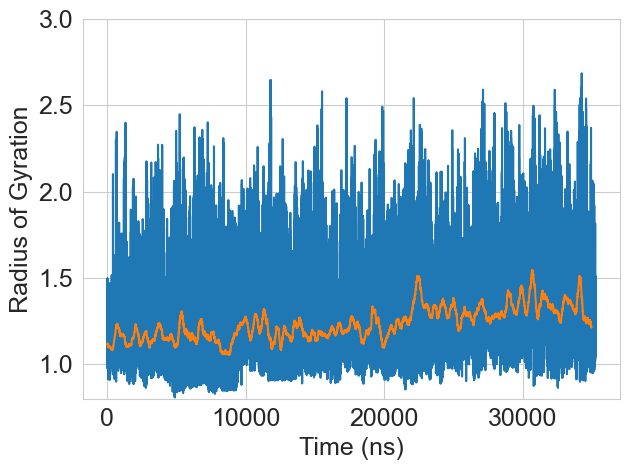

In [25]:
mass = []
for at in trj.topology.atoms:
    mass.append(at.element.mass)
mass_CA = len(mass)*[0.0]
# put the CA entries equal to 1.0
for i in trj.topology.select("name CA"):
    mass_CA[i] = 1.0
# calculate CA radius of gyration
rg_CA = md.compute_rg(trj, masses=np.array(mass_CA))
# SE_rg=(block(rg_all))**.5
plt.clf()
plt.plot(rg_CA)
plt.plot(np.convolve(rg_CA, np.ones(N)/N, mode='valid'))
plt.xlabel('Time (ns)', size=18)
plt.ylabel('Radius of Gyration', size=18)
plt.ylim(0.8, 3.0)
plt.tick_params(labelsize=18)
plt.tight_layout()
print("CA Radius of Gyration:%6.3lf" %
      np.average(rg_CA), "+_%6.3lf" % block(rg_CA)**.5)
print("1st Half CA Radius of Gyration:%6.3lf" % np.average(
    rg_CA[0:half]), "+_%6.3lf" % block(rg_CA[0:half])**.5)
print("2nd Half CA Radius of Gyration:%6.3lf" % np.average(
    rg_CA[half:-1]), "+_%6.3lf" % block(rg_CA[half:-1])**.5)

plt.savefig(outdir+'rg.pdf')
np.savetxt(outdir+'rg.dat', rg_CA)


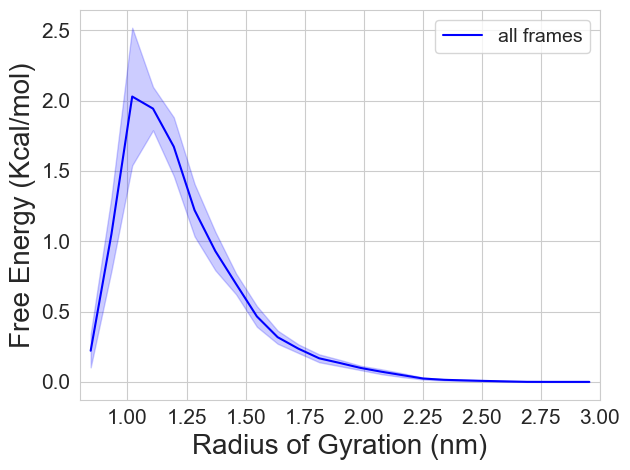

In [26]:
Rg_all, edges, u_err = histo_blockerror(rg_CA, 0.8, 3.0, 25, 5)

plt.plot(edges, Rg_all, c='blue', label='all frames')
plt.fill_between(edges, Rg_all-u_err, Rg_all+u_err, color='blue', alpha=0.2)

plt.xlim(0.8, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()


/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_95193/4034944248.py:64: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


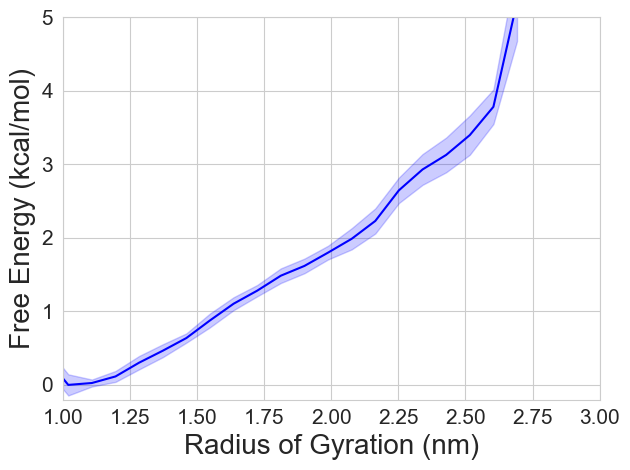

In [27]:
dG, bin_centers, ferr = free_energy_1D_blockerror(rg_CA, 300, 0.8, 3.0, 25, 5)
sns.lineplot(x=bin_centers, y=dG, color='blue')
plt.fill_between(bin_centers, dG-ferr, dG+ferr, color='blue', alpha=0.2)
plt.ylim(-0.2, 5)
plt.xlim(1.0, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
np.savetxt(outdir+'rg.dG.err.dat', np.column_stack((bin_centers, dG, ferr)))
plt.tight_layout()
plt.savefig('%s/Rg.dG.pdf' % outdir)
plt.show()


/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_95193/4034944248.py:64: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


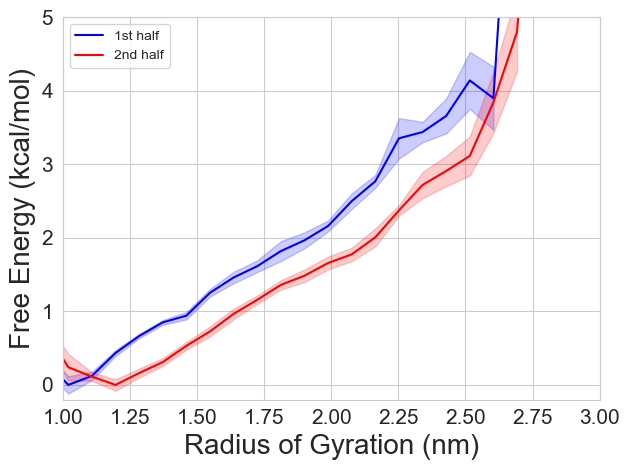

In [28]:
# [0:half],[half:-1]
dG1, bin_centers, ferr1 = free_energy_1D_blockerror(
    rg_CA[0:half], 300, 0.8, 3.0, 25, 5)
dG2, bin_centers, ferr2 = free_energy_1D_blockerror(
    rg_CA[half:-1], 300, 0.8, 3.0, 25, 5)
sns.lineplot(x=bin_centers, y=dG1, color='blue', label='1st half')
sns.lineplot(x=bin_centers, y=dG2, color='red', label='2nd half')

plt.fill_between(bin_centers, dG1-ferr1, dG1+ferr1, color='blue', alpha=0.2)
plt.fill_between(bin_centers, dG2-ferr2, dG2+ferr2, color='red', alpha=0.2)

plt.ylim(-0.2, 5)
plt.xlim(1.0, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.legend()
plt.tight_layout()
plt.tight_layout()
plt.savefig('%s/Rg.dG.splithalfs.pdf' % outdir)
plt.show()


Number of residues: 39

Sα: 3.005 +_ 0.416


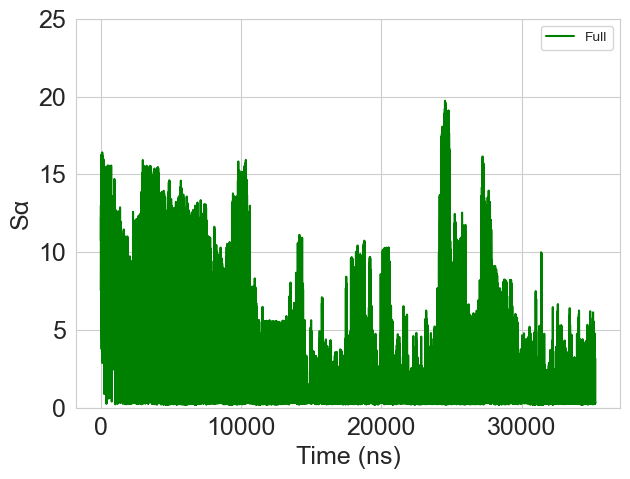

In [29]:
helix = md.load_pdb(helixpdb)
helix
top_helix = helix.topology
backbone_helix = top_helix.select("name CA")
backbone = top.select("name CA")

sel1 = top_helix.select("name CA and resid 0 to 37")

print("Number of residues: %d\n" % len(set(nres)))
RMS_start = 1
RMS_stop = 31
RMS = []
for i in range(RMS_start, RMS_stop):
    sel = top_helix.select("residue %s to %s and backbone" % (i, i+6))
    rmsd = md.rmsd(trj, helix, atom_indices=sel)
    RMS.append(rmsd)
RMS = np.asarray(RMS)
RMS

Sa_sum = np.zeros((trj.n_frames))
Sa = (1.0-(RMS/0.10)**8)/(1-(RMS/0.10)**12)
Sa_ave = np.average(Sa, axis=1)
Sa_total = np.sum(Sa, axis=0)

print("Sα:%6.3lf" % np.average(Sa_total),
      "+_%6.3lf" % block(Sa_total)**.5)

N = 300
plt.plot(Sa_total, label='Full', c='g')
plt.legend()
plt.xlabel('Time (ns)', size=18)
plt.ylabel('Sα', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0, 25)
plt.savefig(outdir+'Sa.timecourse.png')
np.savetxt(outdir+'Sa_total.dat', Sa_total)


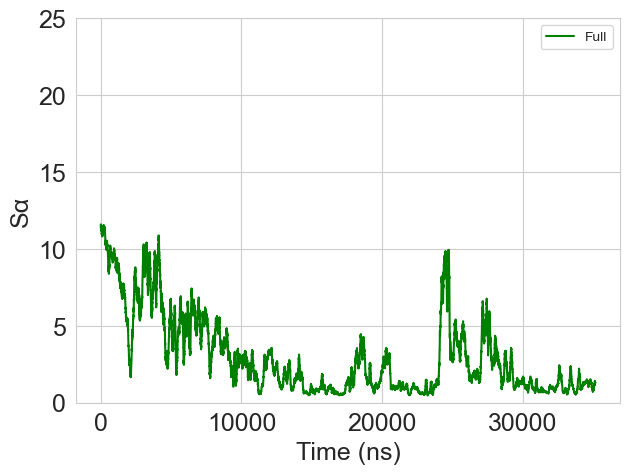

In [30]:
N = 100
plt.plot(np.convolve(Sa_total, np.ones(N)/N, mode='valid'), label='Full', c='g')
# plt.plot(np.convolve(Sa_R2, np.ones(N)/N, mode='valid'), label='R2', c='r')
# plt.plot(np.convolve(Sa_R3, np.ones(N)/N, mode='valid'), label='R3', c='b')
plt.legend()
plt.xlabel('Time (ns)', size=18)
plt.ylabel('Sα', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0, 25)
plt.savefig(outdir+'Sa.timecourse.smooth.png')


In [31]:
# check to see the cooperative helix formation

# check to see the cooperative helix formation

# check to see the cooperative helix formation

first_half_sa = Sa[:15,:]
second_half_sa = Sa[15:, :]

avg_first_half_sa = np.average(first_half_sa,axis=1)
avg_second_half_sa = np.average(second_half_sa,axis=1)

sum_first_half_sa = np.sum(first_half_sa, axis=0)
sum_second_half_sa = np.sum(second_half_sa, axis=0)

cooperative_helix = np.where((sum_first_half_sa > 2) & (sum_second_half_sa > 2))[0] 
c_helix_frac = len(cooperative_helix)/trj.n_frames
print("Sα > 0.2:%6.3lf" % c_helix_frac,
      "+_%6.3lf" % (block(sum_first_half_sa)**2 + block(sum_second_half_sa)**2)**0.5)

Sα > 0.2: 0.176 +_ 0.090


In [32]:
# compute the mutual information
from sklearn.metrics import mutual_info_score

# get the mutual info score of a one-hot encoded array with cutoff. 
first_half_sa_oh = np.where(sum_first_half_sa > 1, 1, 0)
second_half_sa_oh = np.where(sum_second_half_sa > 1, 1, 0)

print(mutual_info_score(first_half_sa_oh, second_half_sa_oh))

0.14160401720772997


In [33]:
# conditional probability 
cooperative_helix = np.where((sum_first_half_sa > 1) & (sum_second_half_sa > 1))[0] 
c_helix_frac = len(cooperative_helix)/trj.n_frames
p_first_half = np.sum(first_half_sa_oh)/ trj.n_frames
p_second_half = np.sum(second_half_sa_oh)/ trj.n_frames

print(c_helix_frac/p_first_half)

0.6469676085458305


**All Frames- Not Partitioned into Bound and Unbound**


/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_95193/4034944248.py:64: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


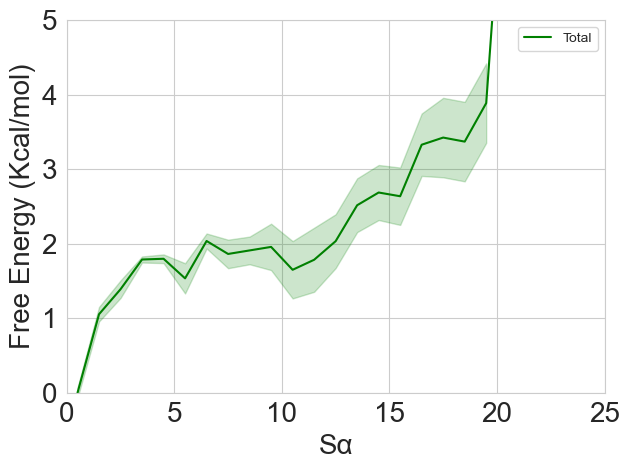

In [34]:
print("**All Frames- Not Partitioned into Bound and Unbound**")
Sa_dg, edges, Sa_err = free_energy_1D_blockerror(Sa_total, 300, 0, 25, 25, 5)
# Sa2_dg, edges, Sa2_err = free_energy_1D_blockerror(Sa_R2, 300, 0, 25, 25, 5)
# Sa3_dg, edges, Sa3_err = free_energy_1D_blockerror(Sa_R3, 300, 0, 25, 25, 5)

plt.clf()
plt.plot(edges, Sa_dg, c='g', label='Total')
# plt.plot(edges, Sa2_dg, c='r', label='R2')
# plt.plot(edges, Sa3_dg, c='b', label='R3')
plt.fill_between(edges, Sa_dg-Sa_err, Sa_dg+Sa_err, color='g', alpha=0.2)
# plt.fill_between(edges, Sa2_dg-Sa2_err, Sa2_dg+Sa2_err, color='r', alpha=0.2)
# plt.fill_between(edges, Sa3_dg-Sa3_err, Sa3_dg+Sa3_err, color='b', alpha=0.2)

plt.legend()

plt.ylim(0, 5)
plt.xlim(0, 25)
plt.xlabel('Sα', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='20')
plt.yticks(size='20')
plt.tight_layout()
np.savetxt(outdir+'Sa_dg.dat', np.column_stack((edges, Sa_dg, Sa_err)))
# np.savetxt(outdir+'Sa.R2dg.dat', np.column_stack((edges, Sa2_dg, Sa2_err)))
# np.savetxt(outdir+'Sa.R3.dg.dat', np.column_stack((edges, Sa3_dg, Sa3_err)))
plt.savefig('%s/Sa.dG.png' % outdir)


In [35]:
# calculate the contacts without the last residue
contact_maps = []
contact_distances = []
for i in range(0, residues):
    contact_map = []
    contact_distance = []
    for j in range(0, residues):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.8, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


In [36]:
seq = []
div = 3
for n,i in enumerate(trj.topology.residues): 
    if n%div == 0: 
        seq.append(str(i))
    else: 
        seq.append("")
seq = seq[:-1] # no ligand in this seq 
seq

['LYS1',
 '',
 '',
 'THR4',
 '',
 '',
 'CYS7',
 '',
 '',
 'GLN10',
 '',
 '',
 'ALA13',
 '',
 '',
 'LEU16',
 '',
 '',
 'SER19',
 '',
 '',
 'ASN22',
 '',
 '',
 'ALA25',
 '',
 '',
 'SER28',
 '',
 '',
 'ASN31',
 '',
 '',
 'SER34',
 '',
 '',
 'TYR37',
 '']

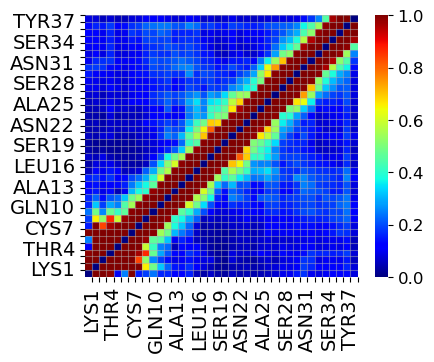

In [37]:
sns.reset_orig()
# the last residue is NH2 
contact_map = final_map
sequence = seq

# Make distance map
fig = plt.figure(figsize=(4.4, 3.4))
ax = fig.add_subplot(111)
im = sns.heatmap(contact_map, cmap='jet', ax=ax)
ax.grid(which='both', alpha=0.5)
plt.xticks(residue_number_offsetres, sequence, rotation=90, size=14)
plt.yticks(residue_number_offsetres, sequence, rotation=0, size=14)
cbar = im.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
#cbar.ax.set_ylabel("kcal mol$^{-1}$", labelpad=20, fontsize=16, rotation=270)
ax.invert_yaxis()

np.savetxt(outdir+'contactmap.dat', final_map)
plt.savefig(outdir+'contact_map.png',bbox_inches = "tight", dpi=400)
plt.savefig(outdir+'contact_map.pdf',bbox_inches = "tight", dpi=400)
plt.show()


In [38]:
contact_map.shape

(38, 38)

In [39]:
a, xedges, yedges = np.histogram2d(
    rg_CA, Sa_total, 30, [[0.9, 2.5], [0, 25.0]], normed=True, weights=None)
a = np.log(np.flipud(a)+.000001)
T = 300
a = -(0.001987*T)*a

fig = plt.figure(figsize=(3.5, 3.2))
im = plt.imshow(a, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5]
plt.xlim(0, 24.9)
# cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
#                   aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("$R_g$", size=22, labelpad=5)
plt.xlabel("Sα", size=22, labelpad=5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(size='16')
plt.yticks(size='16')
#plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
#plt.yticks(size='16')


plt.tight_layout()
np.savetxt(outdir+'Rg_v_Sa.dG.allframes.dat', a)
plt.savefig(outdir+'Rg_v_Sa.dG.allframes.pdf', dpi=400)


In [40]:
yedges

array([0.000, 0.833, 1.667, 2.500, 3.333, 4.167, 5.000, 5.833, 6.667,
       7.500, 8.333, 9.167, 10.000, 10.833, 11.667, 12.500, 13.333,
       14.167, 15.000, 15.833, 16.667, 17.500, 18.333, 19.167, 20.000,
       20.833, 21.667, 22.500, 23.333, 24.167, 25.000])

In [41]:
# Select Ligand Residues
ligand = top.select("residue 39")
# Select Protein Residues
protein = top.select("residue 1 to 38")

ligand_atomid = []
for atom in ligand:
    indices = []
    indices.append(atom)
    indices.append(top.atom(atom))
    ligand_atomid.append(indices)


protein_atomid = []
for atom in protein:
    indices = []
    indices.append(atom)
    indices.append(top.atom(atom))
    protein_atomid.append(indices)

print(ligand_atomid)
print(protein_atomid)


[[533, LIG39-C], [534, LIG39-C1], [535, LIG39-C2], [536, LIG39-C3], [537, LIG39-C4], [538, LIG39-C5], [539, LIG39-C6], [540, LIG39-O], [541, LIG39-N], [542, LIG39-C7], [543, LIG39-C8], [544, LIG39-C9], [545, LIG39-N1], [546, LIG39-C10], [547, LIG39-N2], [548, LIG39-C11], [549, LIG39-C12], [550, LIG39-C13], [551, LIG39-O1], [552, LIG39-N3], [553, LIG39-C14], [554, LIG39-C15], [555, LIG39-C16], [556, LIG39-C17], [557, LIG39-C18], [558, LIG39-C19], [559, LIG39-F], [560, LIG39-C20], [561, LIG39-C21], [562, LIG39-C22], [563, LIG39-C23], [564, LIG39-C24], [565, LIG39-C25], [566, LIG39-H], [567, LIG39-H1], [568, LIG39-H2], [569, LIG39-H3], [570, LIG39-H4], [571, LIG39-H5], [572, LIG39-H6], [573, LIG39-H7], [574, LIG39-H8], [575, LIG39-H9], [576, LIG39-H10], [577, LIG39-H11], [578, LIG39-H12], [579, LIG39-H13], [580, LIG39-H14], [581, LIG39-H15], [582, LIG39-H16], [583, LIG39-H17], [584, LIG39-H18], [585, LIG39-H19], [586, LIG39-H20], [587, LIG39-H21], [588, LIG39-H22], [589, LIG39-H23], [590,

Fraction Bound: 0.6279254489234348


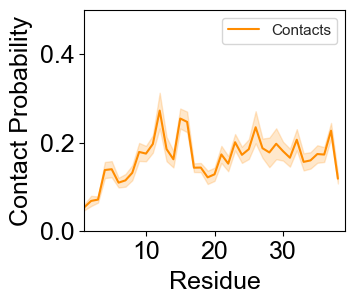

[[1.000 0.054 0.007]
 [2.000 0.069 0.012]
 [3.000 0.072 0.007]
 [4.000 0.139 0.018]
 [5.000 0.140 0.018]
 [6.000 0.110 0.011]
 [7.000 0.115 0.014]
 [8.000 0.132 0.017]
 [9.000 0.179 0.020]
 [10.000 0.176 0.017]
 [11.000 0.197 0.020]
 [12.000 0.273 0.040]
 [13.000 0.186 0.027]
 [14.000 0.163 0.019]
 [15.000 0.255 0.023]
 [16.000 0.247 0.023]
 [17.000 0.144 0.010]
 [18.000 0.144 0.010]
 [19.000 0.122 0.015]
 [20.000 0.129 0.015]
 [21.000 0.174 0.019]
 [22.000 0.153 0.017]
 [23.000 0.201 0.019]
 [24.000 0.173 0.018]
 [25.000 0.186 0.022]
 [26.000 0.235 0.036]
 [27.000 0.188 0.022]
 [28.000 0.178 0.033]
 [29.000 0.198 0.035]
 [30.000 0.181 0.021]
 [31.000 0.166 0.020]
 [32.000 0.207 0.024]
 [33.000 0.157 0.019]
 [34.000 0.160 0.019]
 [35.000 0.175 0.020]
 [36.000 0.173 0.017]
 [37.000 0.227 0.018]
 [38.000 0.119 0.011]]


In [42]:
# Calculate Contact Probabilities between each protein residue and the ligand
#residue_number = range(residue_offset, residue_offset+residues)
contact_pairs = np.zeros((residues, 2))
ligand_residue_index = 38

for i in range(0, residues):
    contact_pairs[i] = [i, ligand_residue_index]
contact = md.compute_contacts(trj, contact_pairs, scheme='closest-heavy')
contacts = np.asarray(contact[0]).astype(float)
cutoff = 0.6
contact_matrix = np.where(contacts < cutoff, 1, 0)
contact_prob = np.sum(contact_matrix, axis=0)/trj.n_frames
np.savetxt(outdir+'contacts.traj.dat', contact_matrix, '%i')


contact_rows = np.sum(contact_matrix, axis=1)
contact_frames = np.where(contact_rows > 0)[0]
nocontact_frames = np.where(contact_rows == 0)[0]
contact_fraction = np.sum(np.where(contact_rows > 0, 1, 0))/len(contact_rows)
print("Fraction Bound:", contact_fraction)

# Total Contacts with errors
contact_ave, contact_pyb_be = get_blockerrors_pyblock(contact_matrix, 1.0)
contact_ave, contact_pyb_be_max = get_blockerrors_pyblock(contact_matrix, 1.0)

contact_be = np.column_stack((range(1,ligand_residue_index+1), contact_ave, contact_pyb_be))
contact_be_max = np.column_stack((range(1,ligand_residue_index+1), contact_ave, contact_pyb_be_max))

np.savetxt('%s/contact.be.pyblock.dat' % outdir, contact_be, '%.4f')
np.savetxt('%s/contact.be.pyblock.max.dat' % outdir, contact_be_max, '%.4f')
sns.set(style='whitegrid')

Contact = contact_be
sns.lineplot(x=Contact[:, 0], y=Contact[:, 1],
             color='darkorange', label='Contacts')
plt.fill_between(Contact[:, 0], Contact[:, 1]+Contact[:, 2],
                 Contact[:, 1]-Contact[:, 2], color='darkorange', alpha=0.2)

plt.xlabel('Residue', size=18)
plt.ylabel('Contact Probability', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues) # off by one because no ligand 
plt.tight_layout()
plt.savefig(outdir+'ContactFraction.byResidue.ClosestHeavy.png')
plt.ylim(0, 0.5)
plt.show()
plt.clf()
print(Contact)


In [43]:
# defined above already, but written here for trial and error 
def get_blockerror(Data):
    data = Data
    average = np.average(data)
    be = block(data)**.5
    return average, be

def protein_atom_specific_probabilities(traj,prot_query, lig_resid = 37, cutoff=0.5): 
    
    # create queries for each 
    lig_atoms = traj.top.select("resid " + str(lig_resid))
    prot_atoms = prot_query # side chains 
    prot_contact_probabilities = []
    prot_contact_probabilities_error = []

    for atoms in prot_atoms: 
        prot_contacts = md.compute_neighbors(traj, cutoff=cutoff, query_indices= atoms,  haystack_indices=lig_atoms, periodic=True)
        prot_contacts = np.array([x.size for x in prot_contacts])
        prot_contacts = np.where(prot_contacts > 0 , 1, 0)
        average, be = get_blockerror(prot_contacts)
        prot_contact_probabilities.append(average)
        prot_contact_probabilities_error.append(be)

    return np.array(prot_contact_probabilities), np.array(prot_contact_probabilities_error)

In [44]:
protein_contact_all_5, protein_contact_all_5_be = protein_atom_specific_probabilities(trj, [trj.topology.select("resid " + str(n)) for n in range(38)], lig_resid=38, cutoff=0.5)
protein_sidechains_all_5, protein_sidechains_all_5_be= protein_atom_specific_probabilities(trj, [trj.topology.select("protein and resid " + str(n) + " and not backbone") for n in range(38)], lig_resid=38, cutoff=0.5)
protein_backbone_all_5, protein_backbone_all_5_be = protein_atom_specific_probabilities(trj, [trj.topology.select("protein and resid " + str(n) + " and backbone") for n in range(38)], lig_resid=38, cutoff=0.5)

/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_95193/4034944248.py:23: RuntimeWarning: invalid value encountered in divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


In [45]:
sequence_ol_s20g = ['K', 'C', 'N', 'T', 'A', 'T', 'C', 'A', 'T', 'Q', 'R', 'L', 'A', 'N', 'F', 'L', 'V', 'H', 'S', 'G', 'N', 'N', 'F', 'G', 'A', 'I', 'L', 'S', 'S', 'T', 'N', 'V', 'G', 'S', 'N', 'T', 'Y', '      NH$_2$']

<Figure size 640x480 with 0 Axes>

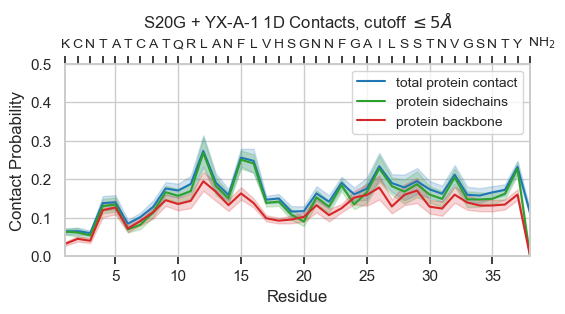

In [46]:
fig, axs = plt.subplots(figsize=(6,2.5))

ax = axs.twiny()
ax.set_xticks(range(0,38))
ax.set_xticklabels([f'{i}' for i in sequence_ol_s20g[::1]], fontsize=10)
ax.grid(False)

axs.plot(hres_renum, protein_contact_all_5, color="tab:blue", label="total protein contact")
axs.fill_between(hres_renum, protein_contact_all_5 + protein_contact_all_5_be, protein_contact_all_5 - protein_contact_all_5_be, alpha=0.2, color="tab:blue")

axs.plot(hres_renum, protein_sidechains_all_5, color="tab:green", label="protein sidechains")
axs.fill_between(hres_renum, protein_sidechains_all_5 + protein_sidechains_all_5_be, protein_sidechains_all_5 - protein_sidechains_all_5_be, alpha=0.2, color="tab:green")

axs.plot(hres_renum, protein_backbone_all_5, color="tab:red", label = "protein backbone")
axs.fill_between(hres_renum, protein_backbone_all_5 + protein_backbone_all_5_be, protein_backbone_all_5 - protein_backbone_all_5_be, alpha=0.2, color="tab:red")

axs.legend(fontsize=10)
axs.set_xlim(1,38)
axs.set_ylim(0,0.5)
axs.set_ylabel("Contact Probability")
axs.set_xlabel("Residue")
axs.set_title("S20G + YX-A-1 1D Contacts, cutoff $ \leq 5 \AA$")
plt.savefig(outdir+'s20g_yxa1_1Dcontacts_total_backbone_sidechains.pdf', bbox_inches="tight", dpi=400)
plt.show()

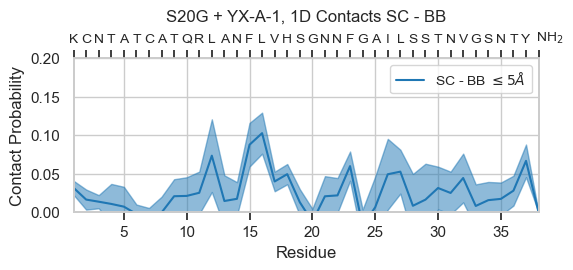

In [47]:
fig, axs = plt.subplots(figsize=(6,2))
side_chain_v_backbone_diff = np.array(protein_sidechains_all_5) - np.array(protein_backbone_all_5)
error = np.sqrt(protein_sidechains_all_5_be**2  + protein_backbone_all_5_be**2)
ax = axs.twiny()
ax.set_xticks(range(0,38))
ax.set_xticklabels([f'{i}' for i in sequence_ol_s20g[::1]], fontsize=10)
ax.grid(False)
axs.plot(hres_renum, side_chain_v_backbone_diff, color="tab:blue", label="SC - BB $ \leq 5 \AA$ ")
axs.fill_between(hres_renum, side_chain_v_backbone_diff + error, side_chain_v_backbone_diff - error, alpha=0.5, color="tab:blue")
axs.legend(fontsize=10)
axs.set_xlim(1,38)
axs.set_ylim(0,0.2)
axs.set_ylabel("Contact Probability")
axs.set_xlabel("Residue")
axs.set_title("S20G + YX-A-1, 1D Contacts SC - BB")
plt.savefig(outdir+'s20g_yxa1_1Dcontacts_total_backbone_sidechains_diff.pdf', bbox_inches="tight", dpi=400)
plt.show()

In [48]:
# just double checking some things here 
# contact_pairs = np.zeros((residues-1, 2))
# ligand_residue_index = 38

# for i in range(0, residues-1):
#     contact_pairs[i] = [i, ligand_residue_index]
# contact = md.compute_contacts(trj, contact_pairs, scheme='closest-heavy')
# contact 

In [49]:
lig_heavy = top.select("(resname LIG) and not (symbol =='H')")
prot_heavy = top.select("(protein) and not (symbol == 'H')")

contact_heavy = np.zeros((33,)) # there are a total of 32 heavy atoms 

for n,i in enumerate(lig_heavy): 
    for k in prot_heavy: 
        dist = md.compute_distances(trj, [[i,k]])
        cutoff = 0.6
        dist_prob = np.sum(np.where(dist < cutoff, 1, 0))/trj.n_frames
        contact_heavy[n] += dist_prob
# divide by number of possible pairs in the end 
contact_heavy

array([3.755, 3.918, 4.185, 3.922, 3.795, 3.456, 4.624, 4.572, 5.168,
       5.786, 6.240, 6.642, 7.136, 7.751, 7.802, 7.238, 6.584, 5.908,
       5.604, 5.759, 5.564, 5.801, 5.818, 5.459, 5.319, 5.290, 6.163,
       8.150, 7.960, 7.714, 7.679, 8.065, 8.220])

In [50]:
len(lig_heavy)*len(prot_heavy)

8910

In [51]:
contact_heavy/(len(lig_heavy)*len(prot_heavy))

array([0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001])

In [52]:
Box_L = trj.unitcell_lengths[0][0]
# Convert nM to meters for Box_V in M^3
Box_V = (Box_L*10**-9)**3
# Convert Box_V to L
Box_V_L = Box_V*1000
#Concentraion in Mols/L
Concentration = 1/(Box_V_L*(6.023*10**23))
print("L:", Box_L, "V:", Box_V, "Conc:", Concentration)

contact_binary = np.where(contact_rows > 0, 1, 0)
boundfrac, boundfrac_be = get_blockerror_pyblock(contact_binary)
print("Bound Fraction:", boundfrac, "+_", boundfrac_be)
upper = boundfrac+boundfrac_be
KD = Kd_calc(boundfrac, Concentration)
KD_upper = Kd_calc(upper, Concentration)
KD_error = KD-KD_upper
print("KD (mM):", KD*1000, "+_", KD_error*1000)


L: 6.4290004 V: 2.6572373841676223e-25 Conc: 0.006248226766973391
10
Bound Fraction: 0.6279254489234348 +_ 0.02366374746857825
KD (mM): 3.7023601660548 +_ 0.3613752002813286


In [53]:
contact_index = []
for i in range(len(contact_binary)):
    if contact_binary[i] == 1:
        contact_index.append(i)

In [54]:
# Time Series of KD Calculations
time = np.linspace(0, 2.8*1000, len(contact_binary))
boundfrac_by_frame = []
t2 = []
err_by_frame = []
err_upper = []
err_lower = []
stride = 100

for i in range(stride, len(contact_binary), stride):
    Data = np.asarray(contact_binary[0:i])
    bf, be = get_blockerror_pyblock_nanskip(Data)
    boundfrac_by_frame.append(bf)
    err_by_frame.append(be)
    err_upper.append(bf-be)
    err_lower.append(bf+be)
    t2.append(time[i])

Kd = Kd_calc(np.asarray(boundfrac_by_frame), Concentration)*1000
Kd_upper = Kd_calc(np.asarray(err_upper), Concentration)*1000
Kd_lower = Kd_calc(np.asarray(err_lower), Concentration)*1000
np.savetxt('%s/KD.timecourse.errors.dat' %
           (outdir), np.column_stack((t2, Kd, Kd_upper, Kd_lower)), '%.4f')

# KD_upper=err_upper
plt.plot(t2, Kd, color='blue')
plt.fill_between(t2, Kd_upper, Kd_lower, color='blue', alpha=0.2)

plt.yticks(fontsize=20)
plt.xticks(fontsize=14)
plt.xlabel('Time (ns)', fontsize=20)
plt.ylabel('$K_D$ (mM)', fontsize=20)
plt.grid(True)
plt.ylim(0, 12.0)
plt.xlim(0, 1600)
plt.tight_layout()
plt.savefig(outdir+'KD.bytime.blockerrors.pdf', bbox_inches='tight')


In [55]:
a, xedges, yedges = np.histogram2d(rg_CA[contact_frames], Sa_total[contact_frames], 30, [
                                   [0.9, 2.5], [0, 25.0]], normed=True, weights=None)
a = np.log(np.flipud(a)+.000001)
T = 300
a = -(0.001987*T)*a

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(a, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.xlim(0, 24.9)
plt.ylabel("Radius of Gryation", size=35, labelpad=15)
plt.xlabel("Sα", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')


plt.tight_layout()
np.savetxt(outdir+'Rg_v_Sa.ligand_contacts.dG.dat', a)
plt.savefig(outdir+'Rg_v_Sa.dG.ligand_contacts.pdf')


In [56]:
# unbound 

a, xedges, yedges = np.histogram2d(rg_CA[nocontact_frames], Sa_total[nocontact_frames], 30, [
                                   [0.9, 2.5], [0, 25.0]], normed=True, weights=None)
a = np.log(np.flipud(a)+.000001)
T = 300
a = -(0.001987*T)*a

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(a, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.xlim(0, 24.9)

plt.ylabel("Radius of Gryation", size=35, labelpad=15)
plt.xlabel("Sα", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')


plt.tight_layout()
np.savetxt(outdir+'Rg_v_Sa.unbound.dG.dat', a)
plt.savefig(outdir+'Rg_v_Sa.dG.unbound.pdf')


In [57]:
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
    array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock


dssp_bound = dsspH1[contact_frames]
dssp_unbound = dsspH1[nocontact_frames]
H1_H_bound, H1_E_bound = dssp_convert(dssp_bound)
H1_H_unbound, H1_E_unbound = dssp_convert(dssp_unbound)

plt.errorbar(hres_renum, H1_H_unbound[:, 0],
             yerr=H1_H_unbound[:, 1], capsize=5, label='Unbound')
plt.errorbar(hres_renum, H1_H_bound[:, 0],
             yerr=H1_H_bound[:, 1], capsize=5, label='Bound')


plt.ylim(0, 1.0)
plt.legend(loc="upper right")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
np.savetxt(outdir+'Hprop.bound.err.dat',
           np.column_stack((hres_renum, H1_H_bound[:, 0], H1_H_bound[:, 1])))
np.savetxt(outdir+'Eprop.bound.err.dat',
           np.column_stack((hres_renum, H1_E_bound[:, 0], H1_E_bound[:, 1])))

np.savetxt(outdir+'Hprop.unbound.err.dat',
           np.column_stack((hres_renum, H1_H_unbound[:, 0], H1_H_unbound[:, 1])))
np.savetxt(outdir+'Eprop.unbound.derr.dat',
           np.column_stack((hres_renum, H1_E_unbound[:, 0], H1_E_unbound[:, 1])))
plt.savefig(outdir+'Hprop.bound.v.unbound.pdf')


dsspH = np.copy(dssp_bound)
dsspH[dsspH == 'H'] = 1
dsspH[dsspH == 'E'] = 0
dsspH[dsspH == 'C'] = 0
dsspH[dsspH == 'NA'] = 0
dsspH = dsspH.astype(int)
TotalH = np.sum(dsspH, axis=1)
np.shape(dsspH1)
TotalH
print("Bound Average Helical Res:%6.3lf" %
      (np.average(TotalH)), "+_%6.3lf" % ((block(TotalH)**.5)))
print("Bound Averagr Fraction Helix:%6.3lf" %
      (np.average(TotalH)/56.0), "+_%6.3lf" % ((block(TotalH)**.5)/37.0))


dsspH = np.copy(dssp_unbound)
dsspH[dsspH == 'H'] = 1
dsspH[dsspH == 'E'] = 0
dsspH[dsspH == 'C'] = 0
dsspH[dsspH == 'NA'] = 0
dsspH = dsspH.astype(int)
TotalH = np.sum(dsspH, axis=1)
np.shape(dsspH1)
TotalH
print("Unbound Average Helical Res:%6.3lf" %
      (np.average(TotalH)), "+_%6.3lf" % ((block(TotalH)**.5)))
print("Unbound Averagr Fraction Helix:%6.3lf" %
      (np.average(TotalH)/residues), "+_%6.3lf" % ((block(TotalH)**.5)/37.0))
print((hres_renum))


Bound Average Helical Res: 7.154 +_ 1.058
Bound Averagr Fraction Helix: 0.128 +_ 0.029
Unbound Average Helical Res: 4.974 +_ 0.496
Unbound Averagr Fraction Helix: 0.131 +_ 0.013
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


Bound Sα: 3.643 +_ 0.723
Unbound Sα: 1.927 +_ 0.302


/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_95193/4034944248.py:64: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


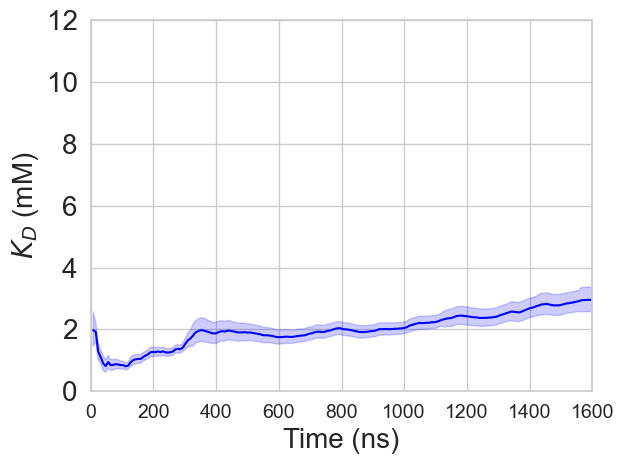

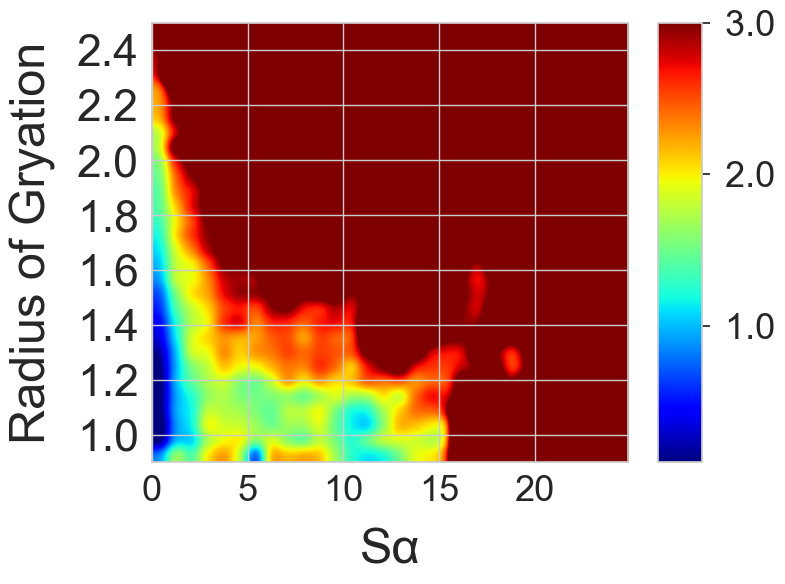

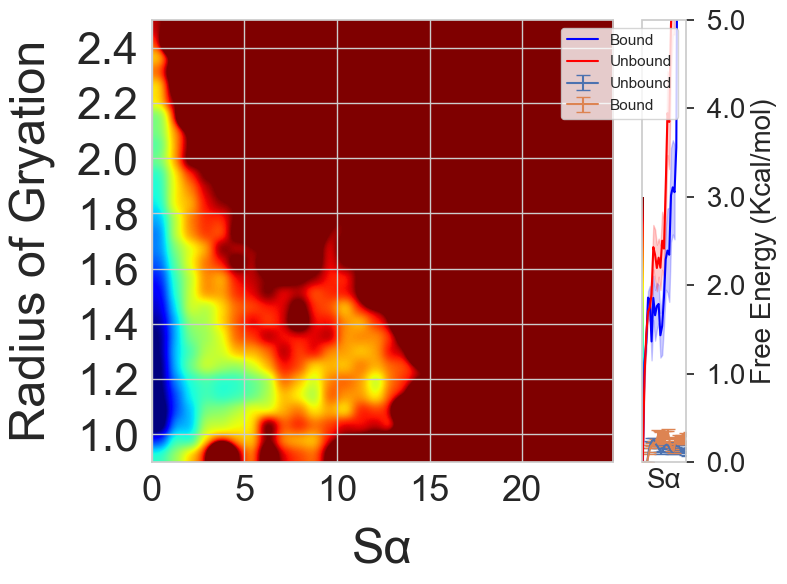

In [58]:
print("Bound Sα:%6.3lf" % np.average(
    Sa_total[contact_frames]), "+_%6.3lf" % block(Sa_total[contact_frames])**.5)
print("Unbound Sα:%6.3lf" % np.average(
    Sa_total[nocontact_frames]), "+_%6.3lf" % block(Sa_total[nocontact_frames])**.5)
np.savetxt(outdir + 'Sa.bf.dat', Sa_total[contact_frames])

dG1, bin_centers, ferr = free_energy_1D_blockerror(
    Sa_total[contact_frames], 300, 0, 25, 25, 5)
dG2, bin_centers, ferr = free_energy_1D_blockerror(
    Sa_total[nocontact_frames], 300, 0, 25, 25, 5)
sns.lineplot(x=bin_centers, y=dG1, color='blue', label="Bound")
sns.lineplot(x=bin_centers, y=dG2, color='red', label="Unbound")
plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color='blue', alpha=0.2)
plt.fill_between(bin_centers, dG2-ferr, dG2+ferr, color='red', alpha=0.2)

plt.ylim(0, 5)
plt.xlim(0, 25)
plt.xlabel('Sα', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='20')
plt.yticks(size='20')
plt.tight_layout()
plt.show()


In [59]:
Sa_dg_b, edges, Sa_b_err = free_energy_1D_blockerror(
    Sa_total[contact_frames], 300, 0, 25, 25, 5)

Sa_dg_u, edges, Sa_u_err = free_energy_1D_blockerror(
    Sa_total[nocontact_frames], 300, 0, 25, 25, 5)

plt.plot(edges, Sa_dg_b, c='g', label='Total Bound')

plt.fill_between(edges, Sa_dg_b-Sa_b_err, Sa_dg_b +
                 Sa_b_err, color='g', alpha=0.5)

plt.plot(edges, Sa_dg_u, c='g', linestyle='dashed', label='Unbound')

plt.fill_between(edges, Sa_dg_u-Sa_u_err, Sa_dg_u +
                 Sa_u_err, color='g', alpha=0.2)

plt.legend()

plt.ylim(0, 5)
plt.xlim(0, 25)
plt.xlabel('Sα', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='20')
plt.yticks(size='20')
plt.tight_layout()
plt.savefig('%s/Sa.dG.compare_bound.png' % outdir)

np.savetxt(outdir+'Sa.bound.dG.dat',
           np.column_stack((edges, Sa_dg_b, Sa_b_err)))

np.savetxt(outdir+'Sa.unbound.dG.dat',
           np.column_stack((edges, Sa_dg_u, Sa_u_err)))


/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_95193/4034944248.py:64: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_95193/4034944248.py:64: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


Bound Rg: 1.197008706419969 +_ 0.014
Unbound Rg: 1.301585515712434 +_ 0.012


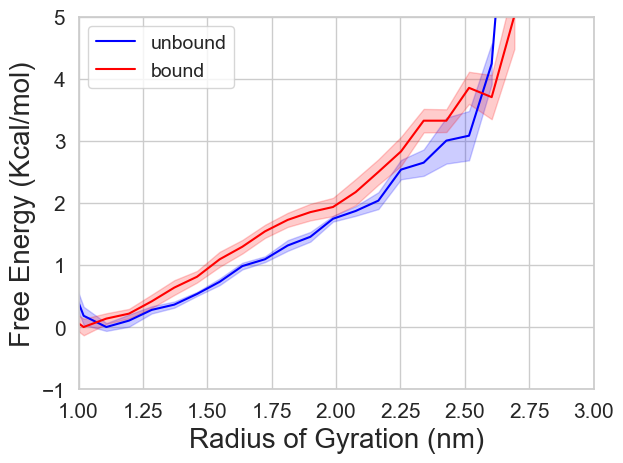

In [60]:
print("Bound Rg:", np.average(rg_CA[contact_frames]),
      "+_%6.3lf" % block(rg_CA[contact_frames])**.5)
print("Unbound Rg:", np.average(
    rg_CA[nocontact_frames]), "+_%6.3lf" % block(rg_CA[nocontact_frames])**.5)
np.savetxt(outdir + 'rg.bf.dat', rg_CA[contact_frames])

Rg_dG_unbound, edges, u_err = free_energy_1D_blockerror(
    rg_CA[nocontact_frames], 300, 0.8, 3.0, 25, 5)
Rg_dG_bound, edges, b_err = free_energy_1D_blockerror(
    rg_CA[contact_frames], 300, 0.8, 3.0, 25, 5)

plt.clf()
plt.plot(edges, Rg_dG_unbound, c='blue', label='unbound')
plt.plot(edges, Rg_dG_bound, c='red', label='bound')
plt.fill_between(edges, Rg_dG_unbound-u_err, Rg_dG_unbound +
                 u_err, color='blue', alpha=0.2)
plt.fill_between(edges, Rg_dG_bound-b_err, Rg_dG_bound +
                 b_err, color='red', alpha=0.2)

plt.ylim(-1, 5)
plt.xlim(1.0, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.legend(loc='upper left', fontsize=14)

plt.tight_layout()
np.savetxt('%s/Rg.dG.bound.dat' %
           outdir, np.column_stack((edges, Rg_dG_bound, b_err)))
np.savetxt('%s/Rg.dG.unbound.dat' %
           outdir, np.column_stack((edges, Rg_dG_unbound, u_err)))
plt.savefig('%s/Rg.dG.compare.pdf' % outdir)
plt.show()

/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_95193/4034944248.py:64: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


Bound Rg: 1.197008706419969 +_ 0.014
Unbound Rg: 1.301585515712434 +_ 0.012
Unbound Rg: 1.2473968674395046 +_ 0.014


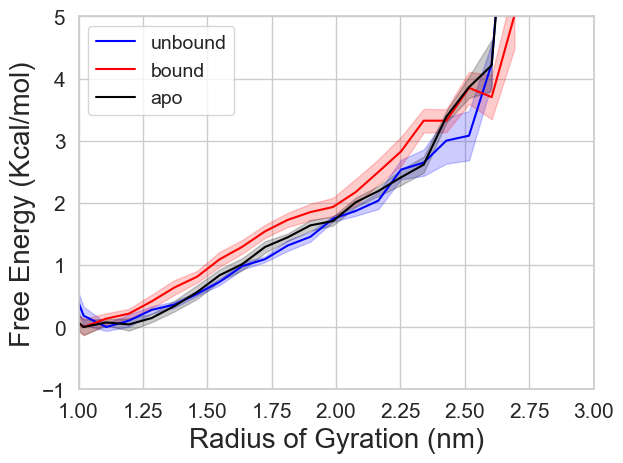

In [61]:
rg_apo = np.loadtxt(apodir+'rg.dat')

print("Bound Rg:", np.average(rg_CA[contact_frames]),
      "+_%6.3lf" % block(rg_CA[contact_frames])**.5)
print("Unbound Rg:", np.average(
    rg_CA[nocontact_frames]), "+_%6.3lf" % block(rg_CA[nocontact_frames])**.5)
print("Unbound Rg:", np.average(rg_apo), "+_%6.3lf" % block(rg_apo)**.5)

Rg_dG_unbound, edges, u_err = free_energy_1D_blockerror(
    rg_CA[nocontact_frames], 300, 0.8, 3.0, 25, 5)
Rg_dG_bound, edges, b_err = free_energy_1D_blockerror(
    rg_CA[contact_frames], 300, 0.8, 3.0, 25, 5)
Rg_dG_apo, edges, a_err = free_energy_1D_blockerror(
    rg_apo, 300, 0.8, 3.0, 25, 5)

plt.clf()
plt.plot(edges, Rg_dG_unbound, c='blue', label='unbound')
plt.plot(edges, Rg_dG_bound, c='red', label='bound')
plt.plot(edges, Rg_dG_apo, c='black', label='apo')

plt.fill_between(edges, Rg_dG_unbound-u_err, Rg_dG_unbound +
                 u_err, color='blue', alpha=0.2)
plt.fill_between(edges, Rg_dG_bound-b_err, Rg_dG_bound +
                 b_err, color='red', alpha=0.2)
plt.fill_between(edges, Rg_dG_apo-a_err, Rg_dG_apo +
                 a_err, color='black', alpha=0.2)

plt.ylim(-1, 5)
plt.xlim(1.0, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.legend(loc='upper left', fontsize=14)

plt.tight_layout()
plt.savefig(outdir+'Rg.dG.compare.wapo.pdf')
plt.show()


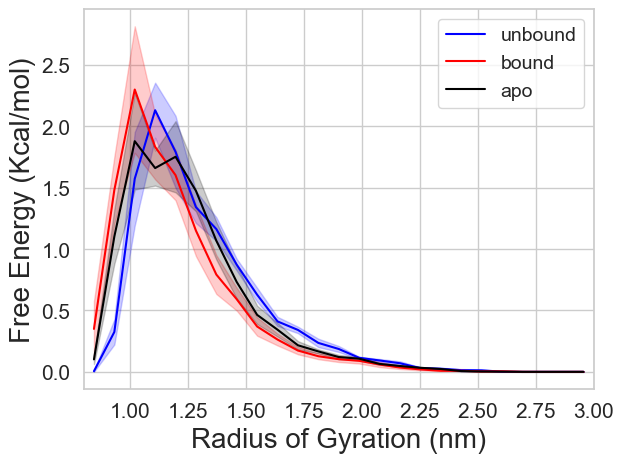

In [62]:
Rg_unbound, edges, u_err = histo_blockerror(
    rg_CA[nocontact_frames], 0.8, 3.0, 25, 5)
Rg_bound, edges, b_err = histo_blockerror(
    rg_CA[contact_frames], 0.8, 3.0, 25, 5)
Rg_apo, edges, a_err = histo_blockerror(rg_apo, 0.8, 3.0, 25, 5)

plt.plot(edges, Rg_unbound, c='blue', label='unbound')
plt.plot(edges, Rg_bound, c='red', label='bound')
plt.plot(edges, Rg_apo, c='black', label='apo')

plt.fill_between(edges, Rg_unbound-u_err, Rg_unbound +
                 u_err, color='blue', alpha=0.2)
plt.fill_between(edges, Rg_bound-b_err, Rg_bound+b_err, color='red', alpha=0.2)
plt.fill_between(edges, Rg_apo-a_err, Rg_apo+a_err, color='black', alpha=0.2)

#plt.ylim(0, 1)
plt.xlim(0.8, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()


In [63]:
def calc_err(contact_binary, name):
    boundfrac_by_frame = []
    t2 = []
    err_by_frame = []
    err_upper = []
    err_lower = []
    time = np.linspace(0, sim_length/len(Sa_total)*len(contact_binary), len(contact_binary))
    srtide = 100
    for i in range(stride, len(contact_binary), stride):
        Data = np.asarray(contact_binary[0:i])
        bf, be = get_blockerror_pyblock_nanskip(Data)
        boundfrac_by_frame.append(bf)
        err_by_frame.append(be)
        err_upper.append(bf-be)
        err_lower.append(bf+be)
        t2.append(time[i])
    np.savetxt(outdir + name, np.column_stack((t2, boundfrac_by_frame, err_upper, err_lower)), '%.4f')

calc_err(rg_CA, 'rg.be.dat')
calc_err(Sa_total, 'Sa.be.dat')
calc_err(rg_CA[contact_index], 'rg.bf.be.dat')
calc_err(Sa_total[contact_index], 'Sa.bf.be.dat')


In [64]:
print(Sa_total)

[7.541 10.123 8.730 ... 0.361 0.350 0.341]


In [65]:
# Calculate Hydrophobic contacts
ligand_hphob = top.select("residue 39 and element C")
protein_hphob = top.select("residue 1 to 38 and element C")


ligand_hphob_atoms = []
for atom in ligand_hphob:
    ligand_hphob_atoms.append(top.atom(atom))

protein_hphob_atoms = []
for atom in protein_hphob:
    protein_hphob_atoms.append(top.atom(atom))

print(ligand_hphob)
print(ligand_hphob_atoms)


def add_contact_pair(pairs, a1, a2, a1_id, a2_id, prot_res, contact_prob):
    if prot_res not in pairs:
        pairs[prot_res] = {}
    if a2 not in pairs[prot_res]:
        pairs[prot_res][a2] = {}
    if a1_id not in pairs[prot_res][a2]:
        pairs[prot_res][a2][a1_id] = contact_prob


hphob_pairs = []
for i in ligand_hphob:
    for j in protein_hphob:
        hphob_pairs.append([i, j])


contact = md.compute_distances(trj, hphob_pairs)
contacts = np.asarray(contact).astype(float)
cutoff = 0.4
contact_frames = np.where(contacts < cutoff, 1, 0)
contact_prob_hphob = np.sum(contact_frames, axis=0)/trj.n_frames


# Hphob Contacts at Atom Pair Resolution
hphob_pair_names = {}
for i in range(0, len(hphob_pairs)):
    a1_id = hphob_pairs[i][0]
    a2_id = hphob_pairs[i][1]
    a1 = top.atom(hphob_pairs[i][0])
    a2 = top.atom(hphob_pairs[i][1])
    prot_res = top.atom(hphob_pairs[i][1]).residue.resSeq
    add_contact_pair(hphob_pair_names, a1, a2, a1_id,
                     a2_id, prot_res, contact_prob_hphob[i])

#residue_number = range(residue_offset, residue_offset+residues)
hphob_max_contacts = {}

# Print Most Populated Contact For Each Aliphatic Carbon in the protein
for i in residue_number:
    if i in hphob_pair_names.keys():
        maxi = 0
        for j in hphob_pair_names[i]:
            max_contact_j = max(
                hphob_pair_names[i][j], key=hphob_pair_names[i][j].get)
            max_contact_fraction = hphob_pair_names[i][j][max_contact_j]
            if max_contact_fraction > maxi:
                max_key_j = j
                max_j_subkey = max_contact_j
                maxi = max_contact_fraction
        hphob_max_contacts[i] = [max_key_j, max_j_subkey, top.atom(
            max_j_subkey), hphob_pair_names[i][max_key_j][max_j_subkey]]


[533 534 535 536 537 538 539 542 543 544 546 548 549 550 553 554 555 556
 557 558 560 561 562 563 564 565]
[LIG39-C, LIG39-C1, LIG39-C2, LIG39-C3, LIG39-C4, LIG39-C5, LIG39-C6, LIG39-C7, LIG39-C8, LIG39-C9, LIG39-C10, LIG39-C11, LIG39-C12, LIG39-C13, LIG39-C14, LIG39-C15, LIG39-C16, LIG39-C17, LIG39-C18, LIG39-C19, LIG39-C20, LIG39-C21, LIG39-C22, LIG39-C23, LIG39-C24, LIG39-C25]


In [66]:
hphob_pair_names

{1: {LYS1-CA: {533: 0.0,
   534: 0.0,
   535: 0.0,
   536: 0.0,
   537: 0.0,
   538: 0.0,
   539: 8.510396868173952e-05,
   542: 0.00011347195824231937,
   543: 5.6735979121159684e-05,
   544: 2.8367989560579842e-05,
   546: 5.6735979121159684e-05,
   548: 5.6735979121159684e-05,
   549: 0.0,
   550: 0.0003971518538481178,
   553: 0.0003404158747269581,
   554: 0.0005957277807721767,
   555: 0.0002836798956057984,
   556: 5.6735979121159684e-05,
   557: 0.0004255198434086976,
   558: 0.0013900314884684123,
   560: 2.8367989560579842e-05,
   561: 5.6735979121159684e-05,
   562: 0.00011347195824231937,
   563: 5.6735979121159684e-05,
   564: 2.8367989560579842e-05,
   565: 0.0},
  LYS1-CB: {533: 0.00011347195824231937,
   534: 0.00011347195824231937,
   535: 2.8367989560579842e-05,
   536: 0.00036878386428753794,
   537: 8.510396868173952e-05,
   538: 8.510396868173952e-05,
   539: 0.00048225582252985733,
   542: 0.00045388783296927747,
   543: 8.510396868173952e-05,
   544: 8.5103968681

In [67]:
# # renumber in this step, but no renumbering needed here 
# original_index = [537, 538, 539, 540, 541, 542, 546, 547, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 562, 563, 564, 566, 568]
# new_index = [0,  1,  2,  3,  4,  5, 9, 10 , 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 29, 31]

# # compute the averages
# hphob_sum = np.zeros((24,)) # num residues, num carbons
# for key in hphob_pair_names.keys(): 
#     # get the key values for that residue and 
#     # average out this property for mapping 
#     for vals in hphob_pair_names[key].values():
#         for n, k in enumerate(original_index): # so as to not lose order 
#             hphob_sum[n] += vals[k]

# hphob_sum = hphob_sum/residues # divide by number of residues 

# # renumber 
# hphob_avg = np.zeros((32,)) # num heavy atoms 
# for i in range(len(hphob_sum)): 
#     hphob_avg[new_index[i]] = hphob_sum[i]
# hphob_avg

In [68]:
contact_frames.shape

(35251, 4264)

1 38


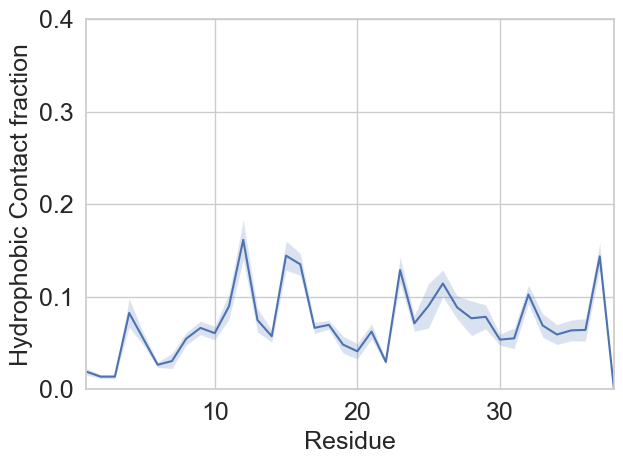

In [69]:
residues = 38
hydrophob_renum = np.arange(1,residues+1)
# Cast hydrophobic contacts as per residue in each frame
Hphob_res_contacts = np.zeros((n_frames, residues)) # offset because no ligand or NH2
for frame in range(n_frames):
    if np.sum(contact_frames[frame]) > 0:
        contact_pairs = np.where(contact_frames[frame] == 1)
        for j in contact_pairs[0]:
            residue = top.atom(hphob_pairs[j][1]).residue.resSeq
            # the 37th index, or NH2 does not have carbons, so leave out 
            # if residue == 37: 
            #     continue
            # else:
            Hphob_res_contacts[frame][residue-1] = 1


np.savetxt(outdir+'hphob_contacts.traj.dat', Hphob_res_contacts, '%i')
hphob_ave, hphob_pyb_be = get_blockerrors_pyblock(Hphob_res_contacts, 1.0)
hphob_by_res = np.column_stack(
    (hydrophob_renum, hphob_ave, hphob_pyb_be))
np.savetxt(outdir+'hphob_contacts.be.dat', hphob_by_res)

plt.plot(hydrophob_renum, hphob_by_res[:, 1])
plt.fill_between(hydrophob_renum,
                 hphob_by_res[:, 1]+hphob_by_res[:, 2], hphob_by_res[:, 1]-hphob_by_res[:, 2], alpha=0.2)

plt.xlabel('Residue', size=18)
plt.ylabel('Hydrophobic Contact fraction', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
print(residue_offset,residues)
plt.ylim(0, 0.4)
plt.tight_layout()
plt.savefig(outdir+"HydrophobicContactFraction.LigandCarbon.ProteinCarbon.pdf")
plt.show()
plt.clf()


hphob_by_res_boundfraction = np.column_stack(
    (hydrophob_renum, hphob_by_res[:, 1]/boundfrac, hphob_by_res[:, 2]/boundfrac))
np.savetxt(outdir+'hphob_contacts.BF.dat', hphob_by_res, fmt='%.4f')
plt.plot(hphob_by_res_boundfraction[:, 0], hphob_by_res_boundfraction[:, 1])
plt.fill_between(hphob_by_res_boundfraction[:, 0], hphob_by_res_boundfraction[:, 1] +
                 hphob_by_res_boundfraction[:, 2], hphob_by_res_boundfraction[:, 1]-hphob_by_res_boundfraction[:, 2], alpha=0.2)
plt.xlabel('Residue', size=18)
plt.ylabel('Hydrophobic Contact fraction', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.ylim(0, 0.4)
plt.tight_layout()
plt.savefig(outdir+"HydrophobicContacts.BoundFraction.pdf")
plt.clf()

In [70]:
hydrophob_renum

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38])

In [71]:
print(hphob_by_res_boundfraction[:, 0],"\n", hphob_by_res_boundfraction[:, 1])

[1.000 2.000 3.000 4.000 5.000 6.000 7.000 8.000 9.000 10.000 11.000
 12.000 13.000 14.000 15.000 16.000 17.000 18.000 19.000 20.000 21.000
 22.000 23.000 24.000 25.000 26.000 27.000 28.000 29.000 30.000 31.000
 32.000 33.000 34.000 35.000 36.000 37.000 38.000] 
 [0.030 0.022 0.022 0.131 0.087 0.042 0.049 0.087 0.106 0.097 0.143 0.257
 0.119 0.091 0.230 0.215 0.106 0.111 0.077 0.065 0.099 0.047 0.205 0.113
 0.144 0.182 0.141 0.122 0.125 0.085 0.088 0.163 0.110 0.094 0.101 0.102
 0.229 0.000]


In [72]:
n_rings = len(ligand_rings)
print("Ligand Aromatics Rings:", n_rings)

ligand_ring_params = []
for i in range(0, n_rings):
    ring = np.array(ligand_rings[i])
    print(ring)
    positions = trj.xyz[:, ring, :]
    print(ligand_rings[i][0], ligand_rings[i][1], ligand_rings[i][2])
    ligand_centers_normals = get_ring_center_normal_trj_assign_atomid(
        positions, 0, 1, 2)
    ligand_ring_params.append(ligand_centers_normals)

prot_rings = []
aro_residues = []
prot_ring_name = []
prot_ring_index = []

aro_select = top.select("resname TYR PHE HIS TRP and name CA")
for i in aro_select:
    atom = top.atom(i)
    resname = atom.residue.name
    print(atom.index, atom.name, atom.residue.name,
          atom.residue, atom.residue.index)
    if resname == "TYR":
        ring = top.select(
            "resid %s and name CG CD1 CD2 CE1 CE2 CZ" % atom.residue.index)
        print(atom.residue, ring)
    if resname == "TRP":
        ring = top.select(
            "resid %s and name CG CD1 NE1 CE2 CD2 CZ2 CE3 CZ3 CH2" % atom.residue.index)
        print(atom.residue, ring)
    if resname == "HIS":
        ring = top.select("resid %s and name CG ND1 CE1 NE2 CD2" %
                          atom.residue.index)
        print(atom.residue, ring)
    if resname == "PHE":
        ring = top.select(
            "resid %s and name CG CD1 CD2 CE1 CE2 CZ" % atom.residue.index)
        print(atom.residue, ring)
    prot_rings.append(ring)
    prot_ring_name.append(atom.residue)
    prot_ring_index.append(atom.residue.index)


print("Protein Aromatics Rings:", len(prot_rings), prot_ring_name)

prot_ring_params = []
for i in range(0, len(prot_rings)):
    ring = np.array(prot_rings[i])
    positions = trj.xyz[:, ring, :]
    ring_centers_normals = get_ring_center_normal_trj_assign_atomid(
        positions, 0, 1, 2)
    prot_ring_params.append(ring_centers_normals)

Ligand Aromatics Rings: 3
[560 561 562 563 564 565]


560 561 562
() (35251, 3) (35251, 3)
[553 554 555 556 557 558]
553 554 555
() (35251, 3) (35251, 3)
[544 545 546 547 548 549]
544 545 546
() (35251, 3) (35251, 3)
206 CA PHE PHE15 14
PHE15 [211 212 214 216 218 220]
261 CA HIS HIS18 17
HIS18 [266 267 268 270 272]
324 CA PHE PHE23 22
PHE23 [329 330 332 334 336 338]
511 CA TYR TYR37 36
TYR37 [516 517 519 521 524 526]
Protein Aromatics Rings: 4 [PHE15, HIS18, PHE23, TYR37]
() (35251, 3) (35251, 3)
() (35251, 3) (35251, 3)
() (35251, 3) (35251, 3)
() (35251, 3) (35251, 3)


In [73]:
frames = n_frames
sidechains = len(prot_rings)
ligrings = len(ligand_rings)
print(frames, sidechains)
Ringstacked_old = {}
Ringstacked = {}
Quadrants = {}
Stackparams = {}
Aro_Contacts = {}
Pstack = {}
Tstack = {}


def normvector_connect(point1, point2):
    vec = point1-point2
    vec = vec/np.sqrt(np.dot(vec, vec))
    return vec


def angle(v1, v2):
    return np.arccos(np.dot(v1, v2)/(np.sqrt(np.dot(v1, v1))*np.sqrt(np.dot(v2, v2))))


for l in range(0, ligrings):
    name = "Lig_ring.%s" % l
    print(name)
    Stackparams[name] = {}
    Pstack[name] = {}
    Tstack[name] = {}
    Aro_Contacts[name] = {}
    alphas = np.zeros(shape=(frames, sidechains))
    betas = np.zeros(shape=(frames, sidechains))
    dists = np.zeros(shape=(frames, sidechains))
    thetas = np.zeros(shape=(frames, sidechains))
    phis = np.zeros(shape=(frames, sidechains))
    pstacked_old = np.zeros(shape=(frames, sidechains))
    pstacked = np.zeros(shape=(frames, sidechains))
    tstacked = np.zeros(shape=(frames, sidechains))
    stacked = np.zeros(shape=(frames, sidechains))
    aro_contacts = np.zeros(shape=(frames, sidechains))

    for i in range(0, frames):
        ligcenter = ligand_ring_params[l][i][0]
        lignormal = ligand_ring_params[l][i][1]
        for j in range(0, sidechains):
            protcenter = prot_ring_params[j][i][0]
            protnormal = prot_ring_params[j][i][1]
            dists[i, j] = np.linalg.norm(ligcenter-protcenter)
            connect = normvector_connect(protcenter, ligcenter)
            # alpha is the same as phi in gervasio/Procacci definition
            alphas[i, j] = np.rad2deg(angle(connect, protnormal))
            betas[i, j] = np.rad2deg(angle(connect, lignormal))
            theta = np.rad2deg(angle(protnormal, lignormal))
            thetas[i, j] = np.abs(theta)-2*(np.abs(theta)
                                            > 90.0)*(np.abs(theta)-90.0)
            phi = np.rad2deg(angle(protnormal, connect))
            phis[i, j] = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)

    for j in range(0, sidechains):
        name2 = prot_ring_index[j]
        res2 = prot_ring_name[j]
        print(name2, res2)
        Ringstack = np.column_stack(
            (dists[:, j], alphas[:, j], betas[:, j], thetas[:, j], phis[:, j]))
        stack_distance_cutoff = 0.65
        r = np.where(dists[:, j] <= stack_distance_cutoff)[0]
        aro_contacts[:, j][r] = 1

        # New Definitions
        # p-stack: r < 6.5 Å, θ < 60° and ϕ < 60°.
        # t-stack: r < 7.5 Å, 75° < θ < 90° and ϕ < 60°.
        p_stack_distance_cutoff = 0.65
        t_stack_distance_cutoff = 0.75
        r_pstrict = np.where(dists[:, j] <= p_stack_distance_cutoff)[0]
        r_tstrict = np.where(dists[:, j] <= t_stack_distance_cutoff)[0]

        e = np.where(thetas[:, j] <= 45)
        f = np.where(phis[:, j] <= 60)
        g = np.where(thetas[:, j] >= 75)

        pnew = np.intersect1d(np.intersect1d(e, f), r_pstrict)
        tnew = np.intersect1d(np.intersect1d(g, f), r_tstrict)
        pstacked[:, j][pnew] = 1
        tstacked[:, j][tnew] = 1
        stacked[:, j][pnew] = 1
        stacked[:, j][tnew] = 1
        total_stacked = len(pnew)+len(tnew)
        print("Contacts:", len(r), "Total:", total_stacked,
              "P-stack:", len(pnew), "T-stack:", len(tnew))
        Stackparams[name][name2] = Ringstack
    Pstack[name] = pstacked
    Tstack[name] = tstacked
    Aro_Contacts[name] = aro_contacts
    Ringstacked[name] = stacked


35251 4
Lig_ring.0
14 PHE15
Contacts: 2664 Total: 1156 P-stack: 917 T-stack: 239
17 HIS18
Contacts: 1254 Total: 576 P-stack: 405 T-stack: 171
22 PHE23
Contacts: 1983 Total: 838 P-stack: 645 T-stack: 193
36 TYR37
Contacts: 2805 Total: 1577 P-stack: 1279 T-stack: 298
Lig_ring.1
14 PHE15
Contacts: 1674 Total: 688 P-stack: 334 T-stack: 354
17 HIS18
Contacts: 988 Total: 378 P-stack: 224 T-stack: 154
22 PHE23
Contacts: 1876 Total: 896 P-stack: 615 T-stack: 281
36 TYR37
Contacts: 1746 Total: 778 P-stack: 526 T-stack: 252
Lig_ring.2
14 PHE15
Contacts: 2259 Total: 1566 P-stack: 1335 T-stack: 231
17 HIS18
Contacts: 1106 Total: 602 P-stack: 438 T-stack: 164
22 PHE23
Contacts: 2025 Total: 1306 P-stack: 1112 T-stack: 194
36 TYR37
Contacts: 2922 Total: 1926 P-stack: 1659 T-stack: 267


1


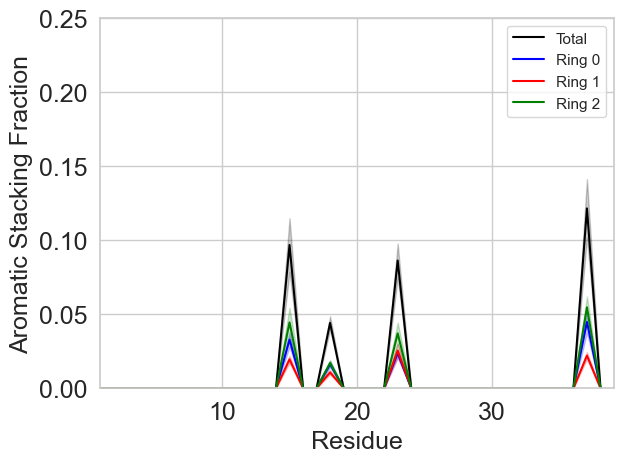

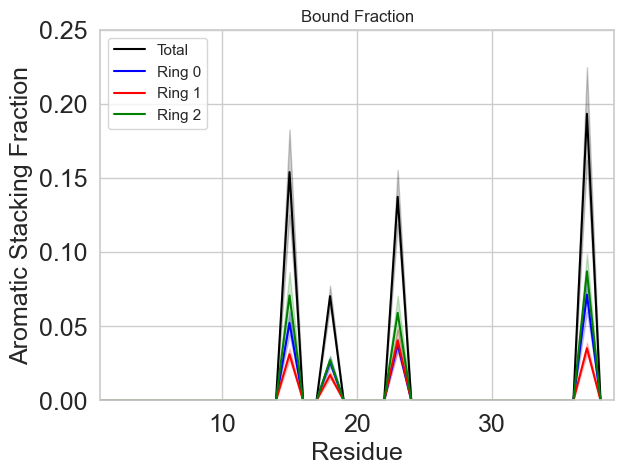

In [74]:
# Cast aromatic contacts as per residue in each frame
print(residue_offset)
residue_number = range(residue_offset , residues + residue_offset) # not including ligand 
aro_res_index = np.array(prot_ring_index)

aromatic_stacking_contacts_r0 = np.zeros((n_frames, residues))
aromatic_stacking_contacts_r1 = np.zeros((n_frames, residues))
aromatic_stacking_contacts_r2 = np.zeros((n_frames, residues))
aromatic_stacking_contacts = np.zeros((n_frames, residues))

aromatic_contacts_r0 = np.zeros((n_frames, residues))
aromatic_contacts_r1 = np.zeros((n_frames, residues))
aromatic_contacts_r2 = np.zeros((n_frames, residues))
aromatic_contacts = np.zeros((n_frames, residues))

# print(aro_res_index)

for i in range(0, len(aro_res_index)):
    aromatic_stacking_contacts_r0[:, aro_res_index[i]
                                  ] = Ringstacked['Lig_ring.0'][:, i]
    aromatic_contacts_r0[:, aro_res_index[i]
                         ] = Aro_Contacts['Lig_ring.0'][:, i]

    aromatic_stacking_contacts_r1[:, aro_res_index[i]
                                  ] = Ringstacked['Lig_ring.1'][:, i]
    aromatic_contacts_r1[:, aro_res_index[i]
                         ] = Aro_Contacts['Lig_ring.1'][:, i]
    
    aromatic_stacking_contacts_r2[:, aro_res_index[i]
                                  ] = Ringstacked['Lig_ring.2'][:, i]
    aromatic_contacts_r2[:, aro_res_index[i]
                         ] = Aro_Contacts['Lig_ring.2'][:, i]

    aromatic_stacking_contacts[:, aro_res_index[i]
                               ] += Ringstacked['Lig_ring.0'][:, i]
    aromatic_stacking_contacts[:, aro_res_index[i]
                               ] += Ringstacked['Lig_ring.1'][:, i]
    aromatic_stacking_contacts[:, aro_res_index[i]
                               ] += Ringstacked['Lig_ring.2'][:, i]

    aromatic_contacts[:, aro_res_index[i]] += Aro_Contacts['Lig_ring.0'][:, i]
    aromatic_contacts[:, aro_res_index[i]] += Aro_Contacts['Lig_ring.1'][:, i]
    aromatic_contacts[:, aro_res_index[i]] += Aro_Contacts['Lig_ring.2'][:, i]


np.savetxt(outdir+'aromatic_stacking.traj.dat',
           aromatic_stacking_contacts, '%i')
aro_ave, aro_pyb_be = get_blockerrors_pyblock(aromatic_stacking_contacts, 1.0)
aro_by_res = np.column_stack((residue_number, aro_ave, aro_pyb_be))
np.savetxt(outdir+'aromatic_stacking.fraction.be.dat', aro_by_res)

np.savetxt(outdir+'aromatic_stacking.traj.r0.dat',
           aromatic_stacking_contacts_r0, '%i')
aro_r0_ave, aro_r0_pyb_be = get_blockerrors_pyblock(
    aromatic_stacking_contacts_r0, 1.0)
aro_r0_by_res = np.column_stack(
    (residue_number, aro_r0_ave, aro_r0_pyb_be))
np.savetxt(outdir+'aromatic_stacking.fraction.r0.be.dat', aro_r0_by_res)

np.savetxt(outdir+'aromatic_stacking.traj.r1.dat',
           aromatic_stacking_contacts_r1, '%i')
aro_r1_ave, aro_r1_pyb_be = get_blockerrors_pyblock(
    aromatic_stacking_contacts_r1, 1.0)
aro_r1_by_res = np.column_stack(
    (residue_number, aro_r1_ave, aro_r1_pyb_be))
np.savetxt(outdir+'aromatic_stacking.fraction.r1.be.dat', aro_r1_by_res)

np.savetxt(outdir+'aromatic_stacking.traj.r2.dat',
           aromatic_stacking_contacts_r2, '%i')
aro_r2_ave, aro_r2_pyb_be = get_blockerrors_pyblock(
    aromatic_stacking_contacts_r2, 1.0)
aro_r2_by_res = np.column_stack(
    (residue_number, aro_r2_ave, aro_r2_pyb_be))
np.savetxt(outdir+'aromatic_stacking.fraction.r2.be.dat', aro_r2_by_res)

plt.plot(aro_by_res[:, 0], aro_by_res[:, 1], color='black', label='Total')
plt.fill_between(aro_by_res[:, 0], aro_by_res[:, 1]+aro_by_res[:, 2],
                 aro_by_res[:, 1]-aro_by_res[:, 2], color='black', alpha=0.2)

plt.plot(aro_r0_by_res[:, 0], aro_r0_by_res[:, 1],
         label='Ring 0', color='blue')
plt.fill_between(aro_r0_by_res[:, 0], aro_r0_by_res[:, 1]+aro_r0_by_res[:, 2],
                 aro_r0_by_res[:, 1]-aro_r0_by_res[:, 2], alpha=0.2, color='blue')

plt.plot(aro_r1_by_res[:, 0], aro_r1_by_res[:, 1], label='Ring 1', color='red')
plt.fill_between(aro_r1_by_res[:, 0], aro_r1_by_res[:, 1]+aro_r1_by_res[:, 2],
                 aro_r1_by_res[:, 1]-aro_r1_by_res[:, 2], alpha=0.2, color='red')

plt.plot(aro_r2_by_res[:, 0], aro_r2_by_res[:, 1], label='Ring 2', color='green')
plt.fill_between(aro_r2_by_res[:, 0], aro_r2_by_res[:, 1]+aro_r2_by_res[:, 2],
                 aro_r2_by_res[:, 1]-aro_r2_by_res[:, 2], alpha=0.2, color='green')

plt.legend()
plt.xlabel('Residue', size=18)
plt.ylabel('Aromatic Stacking Fraction', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues)
plt.ylim(0, 0.25)
plt.tight_layout()
plt.savefig(outdir+'AromaticStackingFraction.pdf')
plt.show()
plt.clf()


# Scale For Bound Faction
aro_by_res_bf = np.column_stack(
    (residue_number, aro_ave/boundfrac, aro_pyb_be/boundfrac))
np.savetxt(outdir+'aromatic_stacking.boundfraction.be.dat', aro_by_res_bf)
aro_r0_by_res_bf = np.column_stack(
    (residue_number, aro_r0_ave/boundfrac, aro_r0_pyb_be/boundfrac))
np.savetxt(outdir+'aromatic_stacking.boundfraction.r0.be.dat', aro_r0_by_res_bf)
aro_r1_by_res_bf = np.column_stack(
    (residue_number, aro_r1_ave/boundfrac, aro_r1_pyb_be/boundfrac))
np.savetxt(outdir+'aromatic_stacking.boundfraction.r1.be.dat', aro_r1_by_res_bf)
aro_r2_by_res_bf = np.column_stack(
    (residue_number, aro_r2_ave/boundfrac, aro_r2_pyb_be/boundfrac))
np.savetxt(outdir+'aromatic_stacking.boundfraction.r2.be.dat', aro_r2_by_res_bf)


plt.plot(aro_by_res_bf[:, 0], aro_by_res_bf[:, 1],
         color='black', label='Total')
plt.fill_between(aro_by_res_bf[:, 0], aro_by_res_bf[:, 1]+aro_by_res_bf[:, 2],
                 aro_by_res_bf[:, 1]-aro_by_res_bf[:, 2], color='black', alpha=0.2)

plt.plot(aro_r0_by_res_bf[:, 0],
         aro_r0_by_res_bf[:, 1], label='Ring 0', color='blue')
plt.fill_between(aro_r0_by_res_bf[:, 0], aro_r0_by_res_bf[:, 1]+aro_r0_by_res_bf[:, 2],
                 aro_r0_by_res_bf[:, 1]-aro_r0_by_res_bf[:, 2], alpha=0.2, color='blue')

plt.plot(aro_r1_by_res_bf[:, 0],
         aro_r1_by_res_bf[:, 1], label='Ring 1', color='red')
plt.fill_between(aro_r1_by_res_bf[:, 0], aro_r1_by_res_bf[:, 1]+aro_r1_by_res_bf[:, 2],
                 aro_r1_by_res_bf[:, 1]-aro_r1_by_res_bf[:, 2], alpha=0.2, color='red')

plt.plot(aro_r2_by_res_bf[:, 0],
         aro_r2_by_res_bf[:, 1], label='Ring 2', color='green')
plt.fill_between(aro_r2_by_res_bf[:, 0], aro_r2_by_res_bf[:, 1]+aro_r2_by_res_bf[:, 2],
                 aro_r2_by_res_bf[:, 1]-aro_r2_by_res_bf[:, 2], alpha=0.2, color='green')


plt.legend()
plt.xlabel('Residue', size=18)
plt.ylabel('Aromatic Stacking Fraction', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues)
plt.ylim(0, 0.25)
plt.tight_layout()
plt.title("Bound Fraction")
plt.savefig(outdir+'AromaticStackingFraction.BoundFraction.pdf')
plt.show()


In [75]:
aro_r1_by_res_bf # double check indexing is correct. 

array([[1.000, 0.000, 0.000],
       [2.000, 0.000, 0.000],
       [3.000, 0.000, 0.000],
       [4.000, 0.000, 0.000],
       [5.000, 0.000, 0.000],
       [6.000, 0.000, 0.000],
       [7.000, 0.000, 0.000],
       [8.000, 0.000, 0.000],
       [9.000, 0.000, 0.000],
       [10.000, 0.000, 0.000],
       [11.000, 0.000, 0.000],
       [12.000, 0.000, 0.000],
       [13.000, 0.000, 0.000],
       [14.000, 0.000, 0.000],
       [15.000, 0.031, 0.004],
       [16.000, 0.000, 0.000],
       [17.000, 0.000, 0.000],
       [18.000, 0.017, 0.002],
       [19.000, 0.000, 0.000],
       [20.000, 0.000, 0.000],
       [21.000, 0.000, 0.000],
       [22.000, 0.000, 0.000],
       [23.000, 0.040, 0.008],
       [24.000, 0.000, 0.000],
       [25.000, 0.000, 0.000],
       [26.000, 0.000, 0.000],
       [27.000, 0.000, 0.000],
       [28.000, 0.000, 0.000],
       [29.000, 0.000, 0.000],
       [30.000, 0.000, 0.000],
       [31.000, 0.000, 0.000],
       [32.000, 0.000, 0.000],
       [33.000, 0

In [76]:
dists = np.arange(0, 10, 0.1)
def sigmoid(x, a, b):
      
    z = np.exp(-(a*x+b))
    sig = 1- 1 / (1 + z)

    return sig
# switch = (1.0-((dists-max)/min)**8)/(1-((dists-max)/min)**12)

plt.plot(dists,sigmoid(dists, 3, -16.3))


[4.588 0.599 3.884 ... 0.032 0.189 2.067]


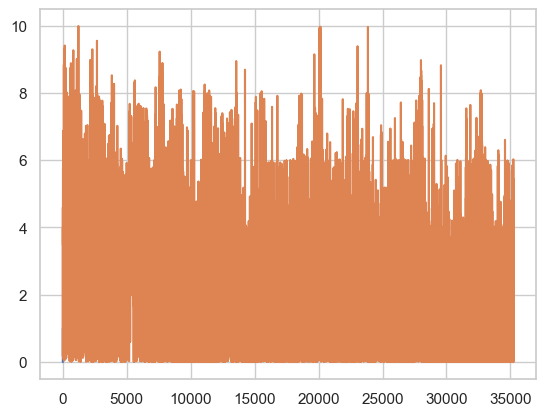

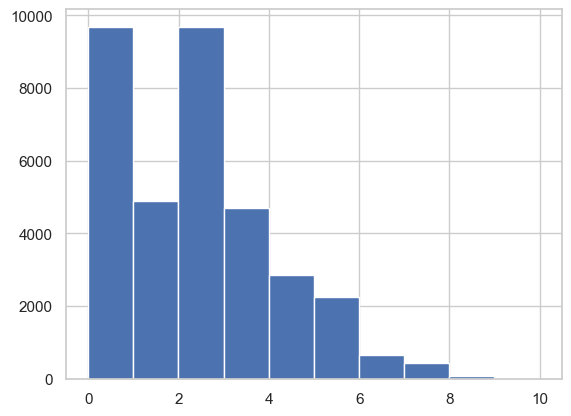

<Figure size 640x480 with 0 Axes>

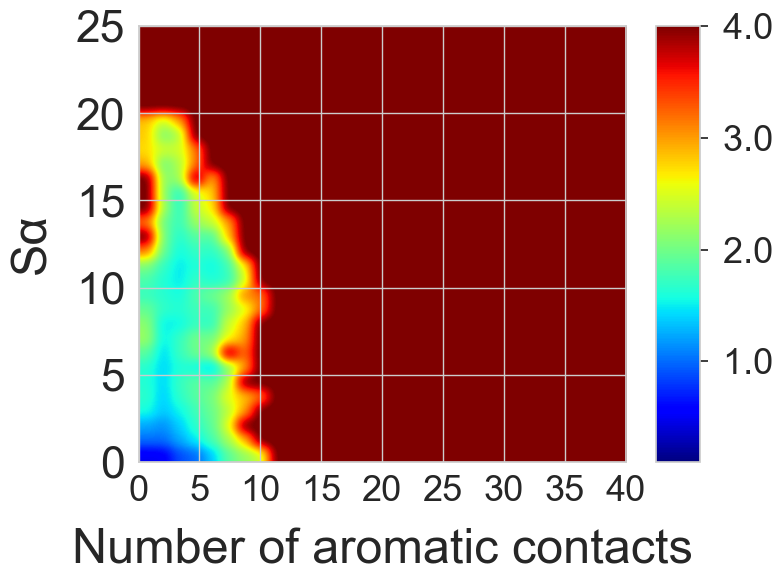

<Figure size 640x480 with 0 Axes>

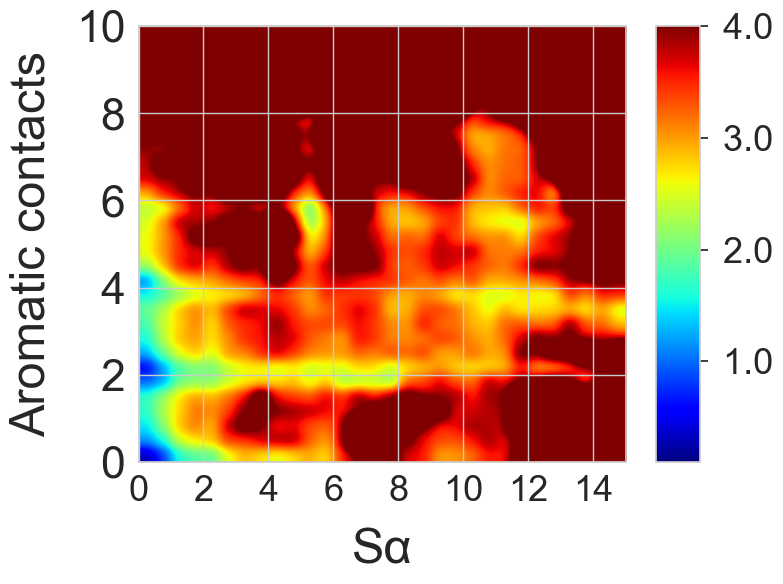

In [77]:
# Protein-protein
# Cut-off 4A, 7A
# 'closest-heavy'
prot_aromatic_res_index = [14,17,22,36]
aromatic_contact_pairs = []
for i in range(len(prot_aromatic_res_index)):
    aromatic_contact_pair = []
    for j in range(len(prot_aromatic_res_index)): 
        pair = [prot_aromatic_res_index[i], prot_aromatic_res_index[j]]
        dist = md.compute_contacts(trj, [pair], scheme='closest-heavy')
        dists = np.asarray(dist[0]).astype(float)
        switch_aro = sigmoid(dists*10, 3, -16.3)
        aromatic_contact_pair.append(switch_aro)
    aromatic_contact_pairs.append(aromatic_contact_pair) 
aromatic_contact_pairs = np.asarray(aromatic_contact_pairs).astype(float)
aromatic_contact_sum = aromatic_contact_pairs.sum(axis = 0).sum(axis = 0)- len(prot_aromatic_res_index)
aromatic_contact_sum = aromatic_contact_sum[:,0]
print(aromatic_contact_sum)
plt.plot(aromatic_contact_sum)
plt.show()
plt.clf()

plt.hist(aromatic_contact_sum)
plt.show()
plt.clf()


dG, xedges, yedges = free_energy(Sa_total, aromatic_contact_sum, 150, 0, 25, 0, 40)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Sα", size=35, labelpad=15)
plt.xlabel("Number of aromatic contacts", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=4.0)
plt.yticks(size='26')
plt.tight_layout()
# np.savetxt(outdir+'Sa_v_aromatic.dG.dat', dG)
plt.savefig(outdir+'Sa_v_aromatic.pdf')
plt.show()
plt.clf()


dG, xedges, yedges = free_energy(aromatic_contact_sum[contact_index], Sa_total[contact_index], 300, 0, 10, 0, 15)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.xlabel("Sα", size=35, labelpad=15)
plt.ylabel("Aromatic contacts", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=4.0)
plt.yticks(size='26')
plt.tight_layout()
plt.show()
# np.savetxt(outdir+'Sa_v_aromatic.dG.dat', dG)
plt.savefig(outdir+'Sa_v_aromatic.bf.pdf')

dG, xedges, yedges = free_energy(aromatic_contact_sum[contact_index], Sa_total[contact_index], 150, 0, 40, 0, 25)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.xlabel("Sα", size=35, labelpad=15)
plt.ylabel("Aromatic contacts", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')
plt.tight_layout()
# np.savetxt(outdir+'Sa_v_aromatic.dG.dat', dG)
plt.savefig(outdir+'Sa_v_aromatic.bf.pdf')

In [78]:
Sa_vs_aromatic = np.column_stack((Sa_total[contact_index], aromatic_contact_sum[contact_index]))
Sa_min = [7.5, 0]
Sa_max = [11, 3]
aromatic_min = [8, 4]
aromatic_max = [16, 11]
basin = []
for i in range(len(Sa_min)):
    Sa_basin = np.where((Sa_vs_aromatic[:, 0] > Sa_min[i]) & (Sa_vs_aromatic[:, 0] < Sa_max[i]))[0]
    aromatic_basin = np.where((Sa_vs_aromatic[:, 1] > aromatic_min[i]) & (Sa_vs_aromatic[:, 1] < aromatic_max[i]))[0]
    basin_index = np.intersect1d(Sa_basin, aromatic_basin)
    newtraj = trj[basin_index]
    md.Trajectory.save_xtc(newtraj, outdir + 'Sa.aromatic.%s.xtc' % i)
    print(newtraj)
    basin.append(basin_index)
print(basin)

<mdtraj.Trajectory with 22 frames, 593 atoms, 39 residues, and unitcells>
<mdtraj.Trajectory with 1579 frames, 593 atoms, 39 residues, and unitcells>
[array([  104,   110,   179,   193,   204,   241,   526,   558,   560,
         645,   648,   665,   892,  1901,  2175,  2177,  2178,  2181,
        2217,  2218,  7060, 17789]), array([ 1144,  1145,  1273, ..., 22127, 22128, 22130])]


<Figure size 640x480 with 0 Axes>

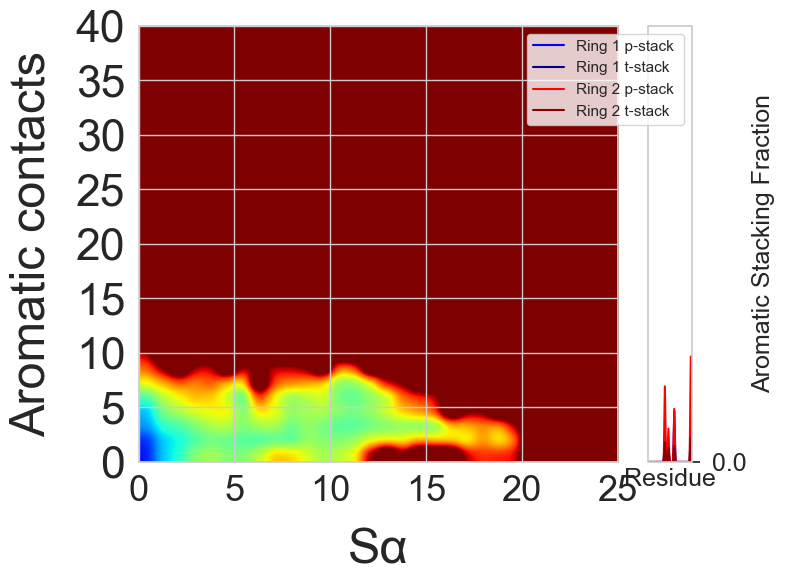

In [79]:
# Cast aromatic contacts as per residue in each frame
aro_res_index = np.array(prot_ring_index)

aromatic_stacking_contacts_r0_p = np.zeros((n_frames, residues))
aromatic_stacking_contacts_r0_t = np.zeros((n_frames, residues))
aromatic_stacking_contacts_r1_p = np.zeros((n_frames, residues))
aromatic_stacking_contacts_r1_t = np.zeros((n_frames, residues))

for i in range(0, len(aro_res_index)):
    aromatic_stacking_contacts_r0_p[:,
                                    aro_res_index[i]] = Pstack['Lig_ring.0'][:, i]
    aromatic_stacking_contacts_r1_p[:,
                                    aro_res_index[i]] = Pstack['Lig_ring.1'][:, i]
    aromatic_stacking_contacts_r0_t[:,
                                    aro_res_index[i]] = Tstack['Lig_ring.0'][:, i]
    aromatic_stacking_contacts_r1_t[:,
                                    aro_res_index[i]] = Tstack['Lig_ring.1'][:, i]

np.savetxt(outdir+'aromatic_pstacking.traj.r0.dat',
           aromatic_stacking_contacts_r0_p, '%i')
aromatic_pstacking_fraction_r0 = np.sum(
    aromatic_stacking_contacts_r0_p, axis=0)/trj.n_frames
np.savetxt(outdir+'aromatic_pstacking.traj.r1.dat',
           aromatic_stacking_contacts_r1_p, '%i')
aromatic_pstacking_fraction_r1 = np.sum(
    aromatic_stacking_contacts_r1_p, axis=0)/trj.n_frames

np.savetxt(outdir+'aromatic_tstacking.traj.r0.dat',
           aromatic_stacking_contacts_r0_t, '%i')
aromatic_tstacking_fraction_r0 = np.sum(
    aromatic_stacking_contacts_r0_t, axis=0)/trj.n_frames
np.savetxt(outdir+'aromatic_tstacking.traj.r1.dat',
           aromatic_stacking_contacts_r1_t, '%i')
aromatic_tstacking_fraction_r1 = np.sum(
    aromatic_stacking_contacts_r1_t, axis=0)/trj.n_frames


aromatic_by_res_r0_p = np.column_stack(
    (residue_number, aromatic_pstacking_fraction_r0/boundfrac))
np.savetxt(outdir+'aromatic_pstacking.fraction.r0.dat',
           aromatic_by_res_r0_p, fmt='%.4f')
aromatic_by_res_r0_t = np.column_stack(
    (residue_number, aromatic_tstacking_fraction_r0/boundfrac))
np.savetxt(outdir+'aromatic_tstacking.fraction.r0.dat',
           aromatic_by_res_r0_t, fmt='%.4f')
aromatic_by_res_r1_p = np.column_stack(
    (residue_number, aromatic_pstacking_fraction_r1/boundfrac))
np.savetxt(outdir+'aromatic_pstacking.fraction.r1.dat',
           aromatic_by_res_r1_p, fmt='%.4f')
aromatic_by_res_r1_t = np.column_stack(
    (residue_number, aromatic_tstacking_fraction_r1/boundfrac))
np.savetxt(outdir+'aromatic_tstacking.fraction.r1.dat',
           aromatic_by_res_r1_t, fmt='%.4f')


plt.plot(residue_number, aromatic_pstacking_fraction_r1,
         label='Ring 1 p-stack ', color='blue')
plt.plot(residue_number, aromatic_tstacking_fraction_r1,
         label='Ring 1 t-stack ', color='darkblue')
plt.plot(residue_number, aromatic_pstacking_fraction_r0,
         label='Ring 2 p-stack ', color='red')
plt.plot(residue_number, aromatic_tstacking_fraction_r0,
         label='Ring 2 t-stack ', color='darkred')

plt.legend()
plt.xlabel('Residue', size=18)
plt.ylabel('Aromatic Stacking Fraction', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.ylim(0, 0.15)
plt.tight_layout()
plt.savefig(outdir+'AromaticStackingFraction.p_vs_t.pdf')
plt.show()
plt.clf()


In [80]:
sidechains = len(prot_rings)
print(n_frames)
stack_distance_cutoff = 0.65
bound_fraction = boundfrac
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print("Ring_Contacts", "Stacked", "P-stacked", "T-stacked")
for j in range(0, sidechains):
    name = prot_ring_index[j]
    res = prot_ring_name[j]
    theta = Stackparams['Lig_ring.0'][name][:, 3]
    newtheta = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(theta)-90.0)
    phi = Stackparams['Lig_ring.0'][name][:, 4]
    newphi = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)
    # Procacci: We define p-stack a domain S in the r, θ, ϕ space as the subset of points such that 3.5 < r < 4.5 Å, θ < 15° and ϕ < 30°.
    # Here: p-stack a domain S in the r<0.6, θ < 45° and ϕ < 45°.
    contacts = np.where(Stackparams['Lig_ring.0']
                        [name][:, 0] <= stack_distance_cutoff)
    b = np.where(newtheta[contacts] <= 45)
    c = np.where(newphi[contacts] <= 60)
    pstack = np.intersect1d(b, c)
    # Procacci: T-stack is the volume of the following T domain: 4.5 < r < 5.5 Å, 75° < θ < 90° and ϕ < 15°.
    # Here :  r < 6.0 Å, 75° < θ < 90° and ϕ < 15°.
    d = np.where(newtheta[contacts] >= 75)
    e = np.where(newphi[contacts] <= 60)
    tstack = np.intersect1d(d, e)
    print(name, res)
    arocontacts = len(contacts[0])/n_frames
    stacked = (len(pstack)+len(tstack))/n_frames
    pstacked = len(pstack)/n_frames
    tstacked = len(tstack)/n_frames
    print("Ring 0: %6.3lf %6.3lf %6.3lf %6.3lf" %
          (arocontacts, stacked, pstacked, tstacked))

    theta = Stackparams['Lig_ring.1'][name][:, 3]
    newtheta = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(theta)-90.0)
    phi = Stackparams['Lig_ring.1'][name][:, 4]
    newphi = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)
    # Procacci: We define p-stack a domain S in the r, θ, ϕ space as the subset of points such that 3.5 < r < 4.5 Å, θ < 15° and ϕ < 30°.
    # Here: p-stack a domain S in the r<0.6, θ < 45° and ϕ < 60°.
    contacts = np.where(Stackparams['Lig_ring.1']
                        [name][:, 0] <= stack_distance_cutoff)
    b = np.where(newtheta[contacts] <= 45)
    c = np.where(newphi[contacts] <= 60)
    pstack = np.intersect1d(b, c)
    # Procacci: T-stack is the volume of the following T domain: 4.5 < r < 5.5 Å, 75° < θ < 90° and ϕ < 15°.
    # Here :  r < 7.5 Å, 45° < θ and ϕ < 60°.
    d = np.where(newtheta[contacts] >= 75)
    e = np.where(newphi[contacts] <= 60)
    tstack = np.intersect1d(c, e)
    arocontacts = len(contacts[0])/n_frames
    stacked = (len(pstack)+len(tstack))/n_frames
    pstacked = len(pstack)/n_frames
    tstacked = len(tstack)/n_frames
    print("Ring 1: %6.3lf %6.3lf %6.3lf %6.3lf" %
          (arocontacts, stacked, pstacked, tstacked))


35251
Ring_Contacts Stacked P-stacked T-stacked
14 PHE15
Ring 0:  0.076  0.030  0.026  0.004
Ring 1:  0.047  0.041  0.009  0.031
17 HIS18
Ring 0:  0.036  0.015  0.011  0.004
Ring 1:  0.028  0.022  0.006  0.016
22 PHE23
Ring 0:  0.056  0.022  0.018  0.004
Ring 1:  0.053  0.051  0.017  0.033
36 TYR37
Ring 0:  0.080  0.043  0.036  0.006
Ring 1:  0.050  0.044  0.015  0.030


<Figure size 640x480 with 0 Axes>

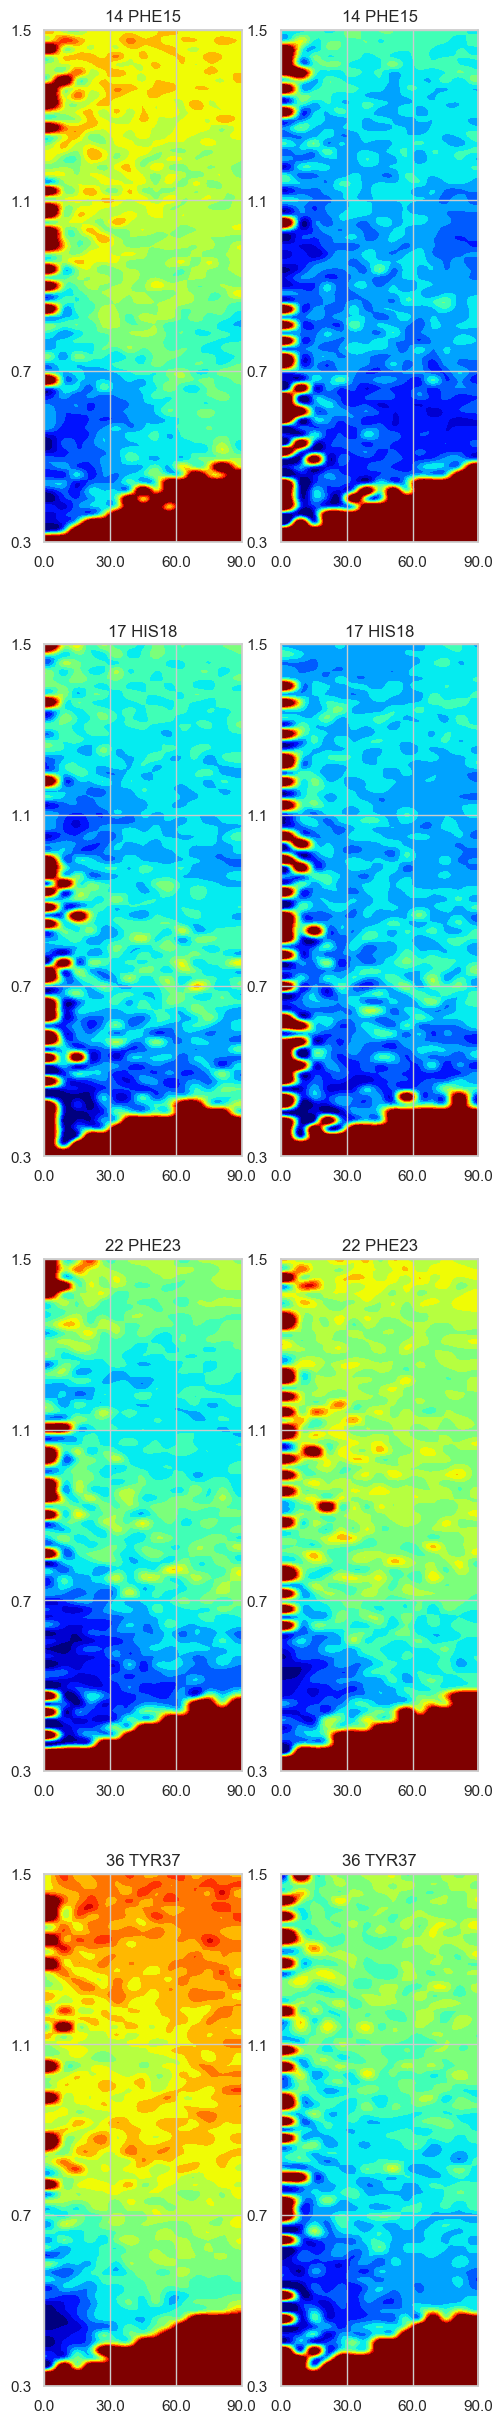

In [81]:
sidechains = len(prot_rings)
fig, ax = plt.subplots(sidechains, 2, figsize=(5.6, 30.6))

y0 = 0
ymax = 90.0
x0 = 0.3
xmax = 1.5
maxangle = ymax
maxdist = xmax
mindist = x0
minangle = y0

j = 0
name = prot_ring_index[j]
res = prot_ring_name[j]
theta = Stackparams['Lig_ring.0'][name][:, 3]
newtheta = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(theta)-90.0)
d = Stackparams['Lig_ring.0'][name][:, 0]
a, xedges, yedges = np.histogram2d(d, newtheta, [65, 15], [[x0, xmax], [
                                   y0, ymax]], normed=True, weights=None)
bin_centers_d = np.zeros((len(xedges)-1, len(yedges)-1))
bin_centers_theta = np.zeros((len(xedges)-1, len(yedges)-1))
norm = np.zeros((len(xedges)-1, len(yedges)-1))
kbT = 300*0.008314/4.184  # kT in kcal/mol

for i in range(1, len(xedges)):
    for j in range(1, len(yedges)):
        bin_centers_d[i-1, j-1] = (xedges[i-1]+xedges[i])/2
        bin_centers_theta[i-1, j-1] = (yedges[j-1]+yedges[j])/2

for i in range(1, len(xedges)):
    for j in range(1, len(yedges)):
        dist = bin_centers_d[i-1, j-1]
        thet = bin_centers_theta[i-1, j-1]
        norm[i-1, j-1] = np.sin(np.deg2rad(thet))*dist**2*a.sum()

for j in range(0, sidechains):
    name = prot_ring_index[j]
    res = prot_ring_name[j]
    theta = Stackparams['Lig_ring.0'][name][:, 3]
    newtheta = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(theta)-90.0)
    d = Stackparams['Lig_ring.0'][name][:, 0]
    a, xedges, yedges = np.histogram2d(d, newtheta, [65, 15], [[x0, xmax], [
                                       y0, ymax]], normed=True, weights=None)

    kbT = 300*0.008314/4.184  # kT in kcal/mol
    dG_norm = np.log((a/norm)+.000001)
    dG_norm = -(kbT)*dG_norm  # Convert to kcal/mol
    minvalue = np.min(dG_norm)
    dG_norm = dG_norm-minvalue
    fes_cutoff = 3.60
    above_threshold = np.where(dG_norm > 5)
    dG_norm[above_threshold] = 5
    ax[j, 0].set_title("%s %s" % (name, res), fontsize=12)
    ax[j, 0].set_xticks(np.linspace(0, maxangle, 4))
    ax[j, 0].set_yticks(np.linspace(mindist, maxdist, 4))
    ax[j, 0].set_xticklabels([str(round(a, 2))
                             for a in np.linspace(0, maxangle, 4)])
    ax[j, 0].set_yticklabels([str(round(a, 2))
                             for a in np.linspace(mindist, maxdist, 4)])
    cmap = plt.get_cmap('jet', 15)
    maxangle = ymax
    maxdist = xmax
    ax[j, 0].imshow(dG_norm, extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
                    origin='lower', aspect='auto', cmap=cmap, interpolation='spline36', vmin=0, vmax=4)

    theta = Stackparams['Lig_ring.1'][name][:, 3]
    newtheta = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(theta)-90.0)
    d = Stackparams['Lig_ring.1'][name][:, 0]
    a, xedges, yedges = np.histogram2d(d, newtheta, [65, 15], [[x0, xmax], [
                                       y0, ymax]], normed=True, weights=None)
    dG_norm = np.log((a/norm)+.000001)
    dG_norm = -(kbT)*dG_norm  # Convert to kcal/mol
    minvalue = np.min(dG_norm)
    dG_norm = dG_norm-minvalue
    fes_cutoff = 3.60
    above_threshold = np.where(dG_norm > 5)
    dG_norm[above_threshold] = 5
    ax[j, 1].imshow(dG_norm, extent=[0, maxangle, mindist, maxdist], origin='lower',
                    aspect='auto', cmap=cmap, interpolation='spline36', vmin=0, vmax=4)
    ax[j, 1].set_title("%s %s" % (name, res), fontsize=12)
    ax[j, 1].set_title("%s %s" % (name, res), fontsize=12)
    ax[j, 1].set_xticks(np.linspace(0, maxangle, 4))
    ax[j, 1].set_yticks(np.linspace(mindist, maxdist, 4))
    ax[j, 1].set_xticklabels([str(round(a, 2))
                             for a in np.linspace(0, maxangle, 4)])
    ax[j, 1].set_yticklabels([str(round(a, 2))
                             for a in np.linspace(mindist, maxdist, 4)])

plt.savefig(outdir+'AromaticStackingFraction.RvTheta.pdf')
plt.show()


In [82]:
#Stackparams['Lig_ring.1'][433][:, 4]

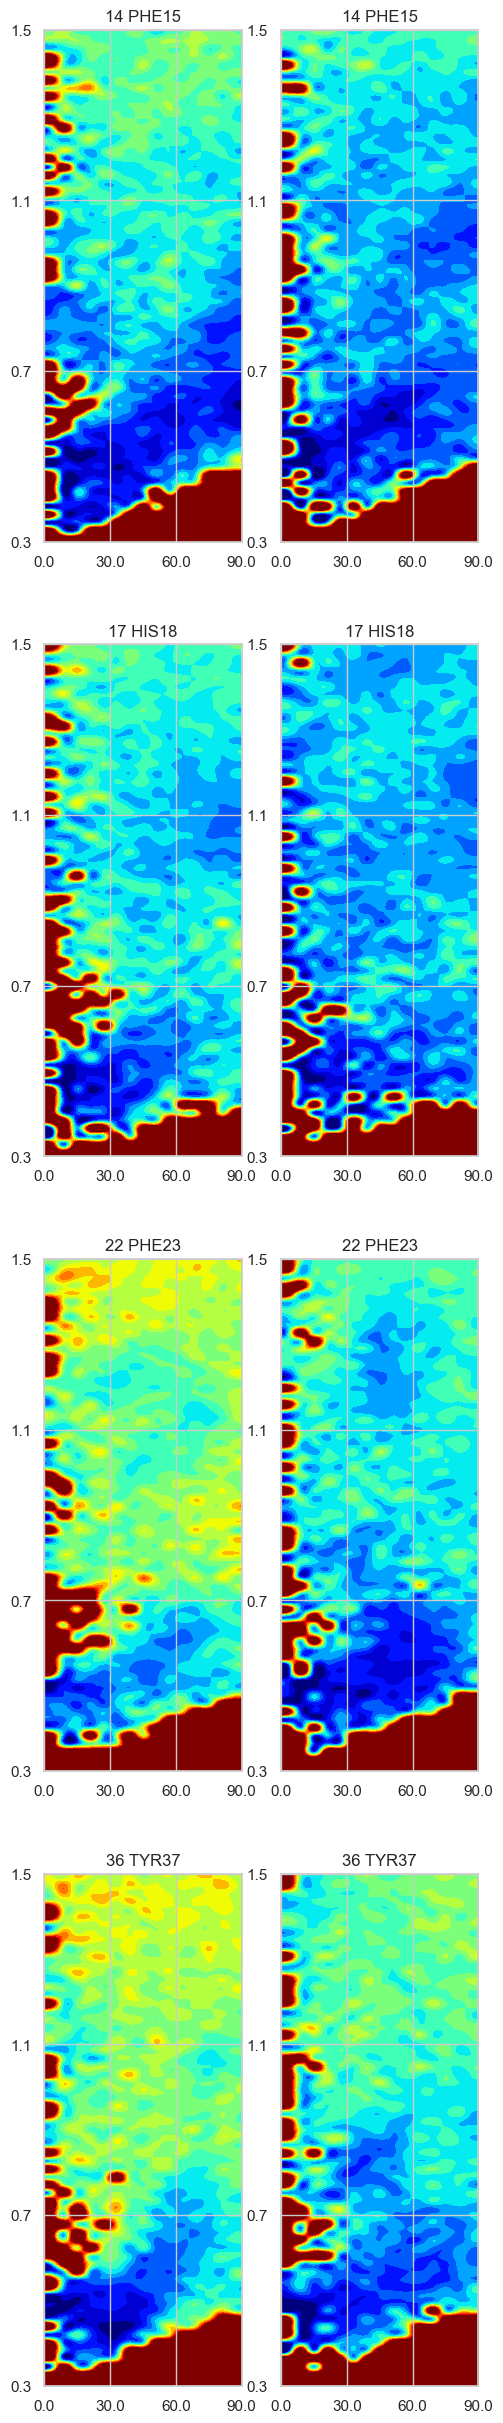

In [83]:
sidechains = len(prot_rings)
fig, ax = plt.subplots(sidechains, 2, figsize=(5.6, 30.6))

y0 = 0
ymax = 90.0
x0 = 0.3
xmax = 1.5
maxangle = ymax
maxdist = xmax
mindist = x0
minangle = y0

j = 0
name = prot_ring_index[j]
res = prot_ring_name[j]
phi = Stackparams['Lig_ring.0'][name][:, 4]
newphi = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(phi)-90.0)
d = Stackparams['Lig_ring.0'][name][:, 0]
a, xedges, yedges = np.histogram2d(d, newtheta, [65, 15], [[x0, xmax], [
                                   y0, ymax]], normed=True, weights=None)
bin_centers_d = np.zeros((len(xedges)-1, len(yedges)-1))
bin_centers_theta = np.zeros((len(xedges)-1, len(yedges)-1))
norm = np.zeros((len(xedges)-1, len(yedges)-1))
kbT = 300*0.008314/4.184  # kT in kcal/mol

for i in range(1, len(xedges)):
    for j in range(1, len(yedges)):
        bin_centers_d[i-1, j-1] = (xedges[i-1]+xedges[i])/2
        bin_centers_theta[i-1, j-1] = (yedges[j-1]+yedges[j])/2

for i in range(1, len(xedges)):
    for j in range(1, len(yedges)):
        dist = bin_centers_d[i-1, j-1]
        thet = bin_centers_theta[i-1, j-1]
        norm[i-1, j-1] = np.sin(np.deg2rad(thet))*dist**2*a.sum()

for j in range(0, sidechains):
    name = prot_ring_index[j]
    res = prot_ring_name[j]
    phi = Stackparams['Lig_ring.0'][name][:, 4]
    newphi = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)
    d = Stackparams['Lig_ring.0'][name][:, 0]
    a, xedges, yedges = np.histogram2d(
        d, newphi, [65, 15], [[x0, xmax], [y0, ymax]], normed=True, weights=None)

    kbT = 300*0.008314/4.184  # kT in kcal/mol
    dG_norm = np.log((a/norm)+.000001)
    dG_norm = -(kbT)*dG_norm  # Convert to kcal/mol
    minvalue = np.min(dG_norm)
    dG_norm = dG_norm-minvalue
    fes_cutoff = 3.60
    above_threshold = np.where(dG_norm > 5)
    dG_norm[above_threshold] = 5
    ax[j, 0].set_title("%s %s" % (name, res), fontsize=12)
    ax[j, 0].set_xticks(np.linspace(0, maxangle, 4))
    ax[j, 0].set_yticks(np.linspace(mindist, maxdist, 4))
    ax[j, 0].set_xticklabels([str(round(a, 2))
                             for a in np.linspace(0, maxangle, 4)])
    ax[j, 0].set_yticklabels([str(round(a, 2))
                             for a in np.linspace(mindist, maxdist, 4)])
    cmap = plt.get_cmap('jet', 15)
    maxangle = ymax
    maxdist = xmax
    ax[j, 0].imshow(dG_norm, extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
                    origin='lower', aspect='auto', cmap=cmap, interpolation='spline36', vmin=0, vmax=4)
    phi = Stackparams['Lig_ring.1'][name][:, 4]
    newphi = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)
    d = Stackparams['Lig_ring.1'][name][:, 0]
    a, xedges, yedges = np.histogram2d(
        d, newphi, [65, 15], [[x0, xmax], [y0, ymax]], normed=True, weights=None)
    dG_norm = np.log((a/norm)+.000001)
    dG_norm = -(kbT)*dG_norm  # Convert to kcal/mol
    minvalue = np.min(dG_norm)
    dG_norm = dG_norm-minvalue
    fes_cutoff = 3.60
    above_threshold = np.where(dG_norm > 5)
    dG_norm[above_threshold] = 5
    ax[j, 1].imshow(dG_norm, extent=[0, maxangle, mindist, maxdist], origin='lower',
                    aspect='auto', cmap=cmap, interpolation='spline36', vmin=0, vmax=4)
    ax[j, 1].set_title("%s %s" % (name, res), fontsize=12)
    ax[j, 1].set_title("%s %s" % (name, res), fontsize=12)
    ax[j, 1].set_xticks(np.linspace(0, maxangle, 4))
    ax[j, 1].set_yticks(np.linspace(mindist, maxdist, 4))
    ax[j, 1].set_xticklabels([str(round(a, 2))
                             for a in np.linspace(0, maxangle, 4)])
    ax[j, 1].set_yticklabels([str(round(a, 2))
                             for a in np.linspace(mindist, maxdist, 4)])
    cmap = plt.get_cmap('jet', 15)

plt.savefig(outdir+'AromaticStackingFraction.RvPhi.pdf')
plt.show()


In [84]:
hbonds = print_donors_acceptors(
    trj[0], angle_cutoff=150, distance_cutoff=0.35, lig_donor_index=lig_hbond_donors)


nh_donors [(0, 1), (0, 2), (0, 3), (18, 19), (18, 20), (18, 21), (24, 25), (34, 35), (43, 44), (43, 45), (48, 49), (62, 63), (72, 73), (86, 87), (96, 97), (106, 107), (120, 121), (132, 133), (132, 134), (137, 138), (150, 151), (153, 154), (153, 155), (156, 157), (156, 158), (161, 162), (180, 181), (190, 191), (199, 200), (199, 201), (204, 205), (224, 225), (243, 244), (259, 260), (270, 271), (276, 277), (287, 288), (294, 295), (303, 304), (303, 305), (308, 309), (317, 318), (317, 319), (322, 323), (342, 343), (349, 350), (359, 360), (378, 379), (397, 398), (408, 409), (419, 420), (433, 434), (442, 443), (442, 444), (447, 448), (463, 464), (470, 471), (481, 482), (490, 491), (490, 492), (495, 496), (509, 510), (530, 531), (530, 532)]
LYS1-N LYS1-H
LYS1-N LYS1-H2
LYS1-N LYS1-H3
LYS1-NZ LYS1-HZ1
LYS1-NZ LYS1-HZ2
LYS1-NZ LYS1-HZ3
CYS2-N CYS2-H
ASN3-N ASN3-H
ASN3-ND2 ASN3-HD21
ASN3-ND2 ASN3-HD22
THR4-N THR4-H
ALA5-N ALA5-H
THR6-N THR6-H
CYS7-N CYS7-H
ALA8-N ALA8-H
THR9-N THR9-H
GLN10-N GLN1

In [85]:
# Select Ligand Residues
ligand = top.select("resid 38")
# Select Protein Residues
protein = top.select("resid 0 to 37")


HBond_PD = np.zeros((n_frames, residues))
HBond_LD = np.zeros((n_frames, residues))
Hbond_pairs_PD = {}
Hbond_pairs_LD = {}


def add_hbond_pair(donor, acceptor, hbond_pairs, donor_res):
    """
    counting the types of bonds with a dictionary donor_res-->donor-->accepptor
    """
    if donor_res not in hbond_pairs:
        hbond_pairs[donor_res] = {}
    if donor not in hbond_pairs[donor_res]:
        hbond_pairs[donor_res][donor] = {}
    if acceptor not in hbond_pairs[donor_res][donor]:
        hbond_pairs[donor_res][donor][acceptor] = 0
    hbond_pairs[donor_res][donor][acceptor] += 1

# Donor & Acceptors Definitions from DESRES paper:
# ligdon = mol.select('chain B and (nitrogen or oxygen or sulfur) and (withinbonds 1 of hydrogen)')
# ligacc = mol.select('chain B and (nitrogen or oxygen or sulfur)')
# protdon = mol.select('chain A and (nitrogen or oxygen or sulfur) and (withinbonds 1 of hydrogen)')
# protacc = mol.select('chain A and (nitrogen or oxygen or sulfur)')


for frame in range(n_frames):
    hbonds = baker_hubbard2(trj[frame], angle_cutoff=150,
                            distance_cutoff=0.35, lig_donor_index=lig_hbond_donors)
    for hbond in hbonds:
        if ((hbond[0] in protein) and (hbond[2] in ligand)):
            donor = top.atom(hbond[0])
            donor_id = hbond[0]
            donor_res = top.atom(hbond[0]).residue.resSeq
            acc = top.atom(hbond[2])
            acc = top.atom(hbond[2])
            acc_res = top.atom(hbond[2]).residue.resSeq
            HBond_PD[frame][donor_res - 1] = 1 # off by one due to indexing 
            add_hbond_pair(donor, acc, Hbond_pairs_PD, donor_res)

        if ((hbond[0] in ligand) and (hbond[2] in protein)):
            donor = top.atom(hbond[0])
            donor_id = hbond[0]
            donor_res = top.atom(hbond[0]).residue.resSeq
            acc = top.atom(hbond[2])
            acc_id = hbond[2]
            acc_res = top.atom(hbond[2]).residue.resSeq
            HBond_LD[frame][acc_res - 1] = 1 # off by one due to indexing 
            add_hbond_pair(donor, acc, Hbond_pairs_LD, acc_res)


In [86]:
# lig_dict = {"N2":8 , "N1":7, "N":6, "N3":12, "O":11, "O1":24, "N4":28, "O2":30}
# hb_prot_to_lig = np.zeros((32,))
# tot_fram = trj.n_frames

# # initialize 
# con_fram = {}
# for i in range(39): 
#     con_fram[i] = 0 

# for key in Hbond_pairs_PD.keys(): 
#     for str_res in Hbond_pairs_PD[key].keys(): 
#         for val in Hbond_pairs_PD[key][str_res].keys(): 
#             count = Hbond_pairs_PD[key][str_res][val]
#             atom_name = str(val).split("-")[1]
#             idx = lig_dict[atom_name]
            
#             # some counting for interactions with N2 and N1, N
#             if val in ['LIG39-N2', 'LIG39-N', 'LIG39-N1']: 
#                 con_fram[int(key)] += count

#             print(idx)
#             hb_prot_to_lig[idx] += count
# hb_prot_to_lig/tot_fram

In [87]:
# # get out values and key pairs 
# x =[]
# y= []
# for i in range(0,39): 
#     x.append(i)
#     y.append(con_fram[i])

# plt.plot(con_fram.keys(), np.array(y)/n_frames, label= "N:8, N:7, and N:6 contributions")
# plt.legend()
# plt.ylabel("Contact Probability")
# plt.xlabel("Residues")
# plt.ylim(top = 0.15, bottom = 0.00)

# np.array(y)/n_frames

In [88]:
# con_fram.keys()

In [89]:
# lig_dict = {"N2":8 , "N1":7, "N":6, "N3":12, "O":11, "O1":24, "N4":28, "O2":30}
# hb_prot_to_lig = np.zeros((32,))
# tot_fram = trj.n_frames

# # Select Ligand Residues
# #ligand = top.select("residue 39")
# ligand = np.arange(537,598)
# # Select Protein Residues
# protein = top.select("residue 1 to 38")

# for hbond in hbonds:
#     # ligand is always the acceptor residue 
#     if hbond[0] in protein: 
#         if hbond[2] in ligand: 
#             print("double T")
#     # if ((hbond[0] in protein) and (hbond[2] in ligand)):
#     #     donor = top.atom(hbond[0])
#     #     acc = top.atom(hbond[2])
#     #     donor_res = top.atom(hbond[0]).residue.resSeq
#     #     count = 1 
#     #     #count = Hbond_pairs_PD[str(donor_res)][str(donor)][str(acc)]
#     #     print(count, "hello")
#     #     atom_name = str(acc).split("-")[1] # grab the atom name 
#     #     idx = int(lig_dict[atom_name])
#     #     hb_prot_to_lig[idx] += float(count)

In [90]:
# np.intersect1d(hbonds[:,2], ligand) 

In [91]:
# for i in range(len(hbonds)):
#     # ligand is always the acceptor residue 
#     if ((hbonds[i][0] in top.select("residue 39")) and top.select("residue 1 to 37")):
#         donor = top.atom(hbond[0])
#         acc = top.atom(hbond[2])
#         print(str(donor), str(acc),"hello")

In [92]:
# #Hbond_pairs_PD gives count based on the total number of frames 
# # identify the ligand atom names with the atoms 

# for key in Hbond_pairs_PD.keys():   
#     for pair in Hbond_pairs_PD[key]: 
#         print(Hbond_pairs_PD[key][pair])
#         #print(str(pair).split("-")) can find out fraction from bb or sc using this line

In [93]:
residue_number = range(residue_offset, residues + residue_offset) # to include ligand? 
print(len(residue_number))

HB_Total = HBond_PD+HBond_LD
HB_Total_ave = np.mean(HB_Total, axis=0)


PD_ave = np.mean(HBond_PD, axis=0)
LD_ave = np.mean(HBond_LD, axis=0)
for i in Hbond_pairs_PD:
    print(i, int(i), Hbond_pairs_PD[i]) # don't have to add an offset here

print("HBond_Ligand Donors")

for i in Hbond_pairs_LD:
    print(i, Hbond_pairs_LD[i])

np.savetxt(outdir+'Hbond.PD.traj.dat', HBond_PD, '%i')
np.savetxt(outdir+'Hbond.LD.traj.dat', HBond_LD, '%i')
np.savetxt(outdir+'Hbond.all.traj.dat', HB_Total, '%i')
hbond_by_res = np.column_stack((residue_number, HB_Total_ave))
hbond_by_res_PD = np.column_stack((residue_number, PD_ave))
hbond_by_res_LD = np.column_stack((residue_number, LD_ave))


HBond_PD_ave, HBond_PD_pyb_be = get_blockerrors_pyblock(HBond_PD, 1.0)
HBond_LD_ave, HBond_LD_pyb_be = get_blockerrors_pyblock(HBond_LD, 1.0)
HBond_ave, HBond_pyb_be = get_blockerrors_pyblock(HB_Total, 1.0)

Hbond_by_res = np.column_stack(
    (residue_number, HBond_ave, HBond_pyb_be))
Hbond_by_res_bf = np.column_stack(
    (residue_number, HBond_ave/boundfrac, HBond_pyb_be/boundfrac))
np.savetxt(outdir+'hbond_fraction.be.dat', Hbond_by_res)
np.savetxt(outdir+'hbond_fraction.boundfraction.be.dat', Hbond_by_res_bf)


Hbond_by_res_LD = np.column_stack(
    (residue_number, HBond_LD_ave, HBond_LD_pyb_be))
np.savetxt(outdir+'hbond_fraction.PD.be.dat', Hbond_by_res_LD)
Hbond_by_res_LD_bf = np.column_stack(
    (residue_number, HBond_LD_ave/boundfrac, HBond_LD_pyb_be/boundfrac))
np.savetxt(outdir+'hbond_fraction.PD.boundfraction.be.dat', Hbond_by_res_LD_bf)


Hbond_by_res_PD = np.column_stack(
    (residue_number, HBond_PD_ave, HBond_PD_pyb_be))
np.savetxt(outdir+'hbond_fraction.LD.be.dat', Hbond_by_res_PD)
Hbond_by_res_PD_bf = np.column_stack(
    (residue_number, HBond_PD_ave/boundfrac, HBond_PD_pyb_be/boundfrac))
np.savetxt(outdir+'hbond_fraction.PD.boundfraction.be.dat', Hbond_by_res_PD_bf)


38
11 11 {ARG11-NH2: {LIG39-O: 38, LIG39-O1: 23, LIG39-N3: 5, LIG39-N2: 2, LIG39-N: 4, LIG39-N1: 1}, ARG11-NE: {LIG39-N1: 3, LIG39-O1: 35, LIG39-O: 29, LIG39-N: 5, LIG39-N3: 5, LIG39-N2: 2}, ARG11-NH1: {LIG39-O: 57, LIG39-O1: 52, LIG39-N1: 6, LIG39-N3: 3, LIG39-N2: 3, LIG39-N: 3}, ARG11-N: {LIG39-N2: 12, LIG39-O1: 13, LIG39-N1: 31, LIG39-O: 42, LIG39-N: 1}}
31 31 {ASN31-ND2: {LIG39-O: 41, LIG39-N1: 174, LIG39-O1: 66, LIG39-N2: 77, LIG39-N: 7, LIG39-N3: 11}, ASN31-N: {LIG39-N1: 1, LIG39-N: 1, LIG39-O: 3, LIG39-N2: 6, LIG39-O1: 1}}
28 28 {SER28-OG: {LIG39-O1: 13, LIG39-O: 65, LIG39-N1: 173, LIG39-N2: 12, LIG39-N: 11, LIG39-N3: 1}, SER28-N: {LIG39-N2: 15, LIG39-O1: 48, LIG39-N3: 2, LIG39-O: 5, LIG39-N1: 1, LIG39-N: 1}}
14 14 {ASN14-ND2: {LIG39-O: 147, LIG39-N: 5, LIG39-N3: 15, LIG39-O1: 87, LIG39-N1: 18, LIG39-N2: 16}, ASN14-N: {LIG39-O: 166, LIG39-O1: 56, LIG39-N2: 8, LIG39-N1: 4, LIG39-N3: 12, LIG39-N: 2}}
21 21 {ASN21-ND2: {LIG39-N2: 57, LIG39-O: 26, LIG39-N: 4, LIG39-N1: 9, LIG39-O1: 

In [94]:
print(Hbond_pairs_LD[27], Hbond_pairs_PD[27])

{LIG39-N3: {LEU27-O: 34, LEU27-N: 18}, LIG39-N: {LEU27-O: 130, LEU27-N: 1}} {LEU27-N: {LIG39-N2: 29, LIG39-N1: 9, LIG39-O: 35, LIG39-O1: 114, LIG39-N3: 5}}


In [95]:
print(Hbond_pairs_LD[20], Hbond_pairs_PD[20])

{LIG39-N3: {GLY20-N: 3, GLY20-O: 50}, LIG39-N: {GLY20-O: 8, GLY20-N: 1}} {GLY20-N: {LIG39-N2: 10, LIG39-N1: 7, LIG39-N3: 2, LIG39-O: 7, LIG39-N: 1, LIG39-O1: 4}}


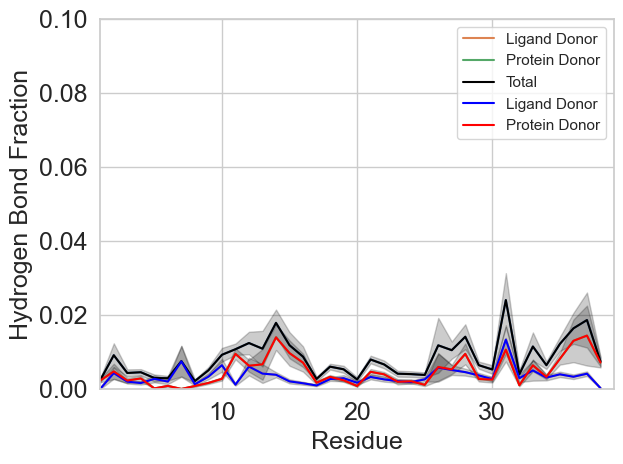

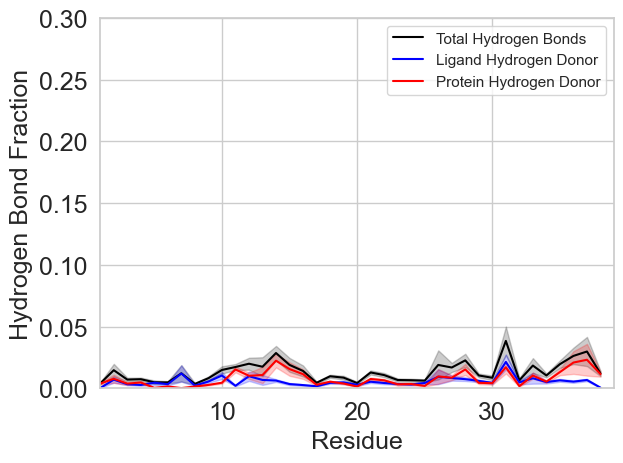

In [96]:
residue_number = range(residue_offset, residue_offset+residues)
plt.plot(residue_number, HB_Total_ave)
plt.plot(residue_number, LD_ave, label="Ligand Donor")
plt.plot(residue_number, PD_ave, label="Protein Donor")


plt.plot(Hbond_by_res[:, 0], Hbond_by_res[:, 1], color='black', label='Total')
plt.fill_between(Hbond_by_res[:, 0], Hbond_by_res[:, 1]+Hbond_by_res[:, 2],
                 Hbond_by_res[:, 1]-Hbond_by_res[:, 2], color='black', alpha=0.2)
plt.plot(Hbond_by_res_LD[:, 0], Hbond_by_res_LD[:, 1],
         color='blue', label='Ligand Donor')
plt.fill_between(Hbond_by_res_LD[:, 0], Hbond_by_res_LD[:, 1]+Hbond_by_res_LD[:, 2],
                 Hbond_by_res_LD[:, 1]-Hbond_by_res_LD[:, 2], color='black', alpha=0.2)
plt.plot(Hbond_by_res_PD[:, 0], Hbond_by_res_PD[:, 1],
         color='red', label='Protein Donor')
plt.fill_between(Hbond_by_res_PD[:, 0], Hbond_by_res_PD[:, 1]+Hbond_by_res_PD[:, 2],
                 Hbond_by_res_PD[:, 1]-Hbond_by_res_PD[:, 2], color='black', alpha=0.2)


plt.legend()
plt.ylim(0, 0.10)
plt.xlabel('Residue', size=18)
plt.ylabel('Hydrogen Bond Fraction', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues)
plt.tight_layout()
plt.savefig(outdir+'HbondFraction.allframes.pdf')
plt.show()
plt.clf()


plt.plot(Hbond_by_res_bf[:, 0], Hbond_by_res_bf[:, 1],
         color='black', label='Total Hydrogen Bonds')
plt.fill_between(Hbond_by_res_bf[:, 0], Hbond_by_res_bf[:, 1]+Hbond_by_res_bf[:, 2],
                 Hbond_by_res_bf[:, 1]-Hbond_by_res_bf[:, 2], color='black', alpha=0.2)
plt.plot(Hbond_by_res_LD_bf[:, 0], Hbond_by_res_LD_bf[:,
         1], color='blue', label='Ligand Hydrogen Donor')
plt.fill_between(Hbond_by_res_LD_bf[:, 0], Hbond_by_res_LD_bf[:, 1]+Hbond_by_res_LD_bf[:, 2],
                 Hbond_by_res_LD_bf[:, 1]-Hbond_by_res_LD_bf[:, 2], color='blue', alpha=0.2)
plt.plot(Hbond_by_res_PD_bf[:, 0], Hbond_by_res_PD_bf[:,
         1], color='red', label='Protein Hydrogen Donor')
plt.fill_between(Hbond_by_res_PD_bf[:, 0], Hbond_by_res_PD_bf[:, 1]+Hbond_by_res_PD_bf[:, 2],
                 Hbond_by_res_PD_bf[:, 1]-Hbond_by_res_PD_bf[:, 2], color='red', alpha=0.2)


plt.legend()
plt.xlabel('Residue', size=18)
plt.ylabel('Hydrogen Bond Fraction', size=18)
plt.ylim(0, 0.30)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues)
plt.tight_layout()
plt.savefig(outdir+'HbondFraction.boundfraction.pdf')
plt.show()
plt.clf()


In [97]:
print(Hbond_by_res_bf)

[[1.000 0.004 0.001]
 [2.000 0.015 0.005]
 [3.000 0.007 0.002]
 [4.000 0.007 0.001]
 [5.000 0.005 0.002]
 [6.000 0.005 0.001]
 [7.000 0.012 0.007]
 [8.000 0.004 0.001]
 [9.000 0.008 0.001]
 [10.000 0.015 0.003]
 [11.000 0.017 0.002]
 [12.000 0.020 0.005]
 [13.000 0.017 0.008]
 [14.000 0.029 0.006]
 [15.000 0.019 0.006]
 [16.000 0.014 0.004]
 [17.000 0.004 0.001]
 [18.000 0.010 0.001]
 [19.000 0.009 0.002]
 [20.000 0.004 0.001]
 [21.000 0.013 0.002]
 [22.000 0.011 0.002]
 [23.000 0.007 0.001]
 [24.000 0.007 0.001]
 [25.000 0.006 0.001]
 [26.000 0.019 0.012]
 [27.000 0.017 0.004]
 [28.000 0.023 0.005]
 [29.000 0.010 0.002]
 [30.000 0.008 0.002]
 [31.000 0.038 0.012]
 [32.000 0.006 0.002]
 [33.000 0.018 0.006]
 [34.000 0.010 0.002]
 [35.000 0.020 0.003]
 [36.000 0.026 0.007]
 [37.000 0.030 0.012]
 [38.000 0.012 0.002]]


In [98]:
print(Hbond_by_res_LD[:, 1], "\n",Hbond_by_res_LD[:, 0])

[0.000 0.004 0.002 0.002 0.003 0.002 0.008 0.001 0.003 0.006 0.001 0.006
 0.004 0.004 0.002 0.002 0.001 0.003 0.003 0.002 0.003 0.003 0.002 0.002
 0.003 0.006 0.005 0.005 0.004 0.003 0.013 0.003 0.005 0.003 0.004 0.003
 0.004 0.000] 
 [1.000 2.000 3.000 4.000 5.000 6.000 7.000 8.000 9.000 10.000 11.000
 12.000 13.000 14.000 15.000 16.000 17.000 18.000 19.000 20.000 21.000
 22.000 23.000 24.000 25.000 26.000 27.000 28.000 29.000 30.000 31.000
 32.000 33.000 34.000 35.000 36.000 37.000 38.000]


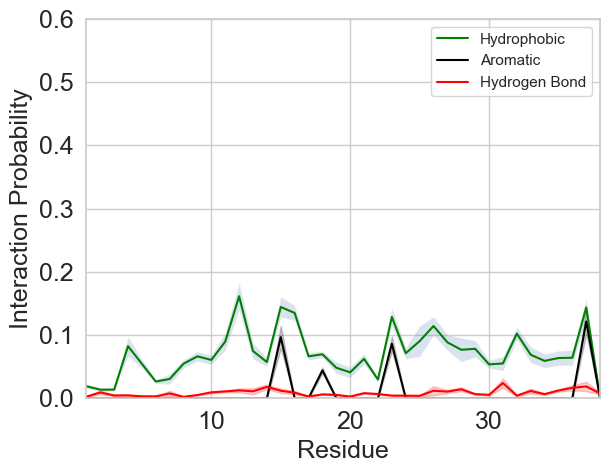

In [99]:
plt.plot(range(1,residues+1),
         hphob_by_res[:, 1], label='Hydrophobic', color='green')
plt.fill_between(range(1,residues+1),
                 hphob_by_res[:, 1]+hphob_by_res[:, 2], hphob_by_res[:, 1]-hphob_by_res[:, 2], alpha=0.2)

plt.plot(aro_by_res[:, 0], aro_by_res[:, 1], color='black', label='Aromatic')
plt.fill_between(aro_by_res[:, 0], aro_by_res[:, 1]+aro_by_res[:, 2],
                 aro_by_res[:, 1]-aro_by_res[:, 2], color='black', alpha=0.2)

plt.plot(Hbond_by_res[:, 0], Hbond_by_res[:, 1],
         label='Hydrogen Bond', color='red')
plt.fill_between(Hbond_by_res[:, 0], Hbond_by_res[:, 1]+Hbond_by_res[:, 2],
                 Hbond_by_res[:, 1]-Hbond_by_res[:, 2], color='red', alpha=0.2)

plt.xlabel('Residue', size=18)
plt.ylabel('Interaction Probability', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.legend()
plt.tight_layout()
plt.savefig(outdir+'LigandInteractions.allframes.pdf')
plt.ylim(0, 0.6)
plt.show()
plt.clf()

<Figure size 640x480 with 0 Axes>

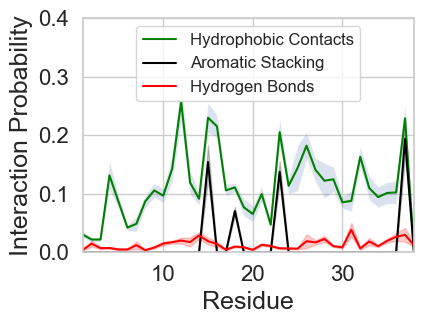

In [100]:
sns.set_style("whitegrid")
plt.clf()
plt.figure(figsize=(4.4,3.4))
plt.plot(range(1,residues+1),
         hphob_by_res[:, 1]/boundfrac, label='Hydrophobic Contacts', color='green')
plt.fill_between(range(1,residues+1), hphob_by_res[:, 1]/boundfrac+hphob_by_res[:, 2] /
                 boundfrac, hphob_by_res[:, 1]/boundfrac-hphob_by_res[:, 2]/boundfrac, alpha=0.2)

plt.plot(aro_by_res[:, 0], aro_by_res[:, 1]/boundfrac,
         color='black', label='Aromatic Stacking')
plt.fill_between(aro_by_res[:, 0], aro_by_res[:, 1]/boundfrac+aro_by_res[:, 2]/boundfrac,
                 aro_by_res[:, 1]/boundfrac-aro_by_res[:, 2]/boundfrac, color='black', alpha=0.2)

plt.plot(Hbond_by_res[:, 0], Hbond_by_res[:, 1] /
         boundfrac, label='Hydrogen Bonds', color='red')
plt.fill_between(Hbond_by_res[:, 0], Hbond_by_res[:, 1]/boundfrac+Hbond_by_res[:, 2]/boundfrac,
                 Hbond_by_res[:, 1]/boundfrac-Hbond_by_res[:, 2]/boundfrac, color='red', alpha=0.2)

plt.xlabel('Residue', size=18)
plt.ylabel('Interaction Probability', size=18)
plt.tick_params(labelsize=16)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.ylim(0, 0.4)
plt.legend(fontsize=12, loc="upper center")
#plt.title("Bound Ensemble",size=18)
plt.tight_layout()
plt.savefig(outdir+'LigandInteractions.boundfraction.pdf',bbox_inches="tight",dpi=400)
plt.show()
plt.clf()


In [101]:
print("aro_by_res x and y", aro_by_res)
print("aro_by_res_bf x and y ",aro_by_res_bf)

aro_by_res x and y [[1.000 0.000 0.000]
 [2.000 0.000 0.000]
 [3.000 0.000 0.000]
 [4.000 0.000 0.000]
 [5.000 0.000 0.000]
 [6.000 0.000 0.000]
 [7.000 0.000 0.000]
 [8.000 0.000 0.000]
 [9.000 0.000 0.000]
 [10.000 0.000 0.000]
 [11.000 0.000 0.000]
 [12.000 0.000 0.000]
 [13.000 0.000 0.000]
 [14.000 0.000 0.000]
 [15.000 0.097 0.018]
 [16.000 0.000 0.000]
 [17.000 0.000 0.000]
 [18.000 0.044 0.004]
 [19.000 0.000 0.000]
 [20.000 0.000 0.000]
 [21.000 0.000 0.000]
 [22.000 0.000 0.000]
 [23.000 0.086 0.011]
 [24.000 0.000 0.000]
 [25.000 0.000 0.000]
 [26.000 0.000 0.000]
 [27.000 0.000 0.000]
 [28.000 0.000 0.000]
 [29.000 0.000 0.000]
 [30.000 0.000 0.000]
 [31.000 0.000 0.000]
 [32.000 0.000 0.000]
 [33.000 0.000 0.000]
 [34.000 0.000 0.000]
 [35.000 0.000 0.000]
 [36.000 0.000 0.000]
 [37.000 0.121 0.020]
 [38.000 0.000 0.000]]
aro_by_res_bf x and y  [[1.000 0.000 0.000]
 [2.000 0.000 0.000]
 [3.000 0.000 0.000]
 [4.000 0.000 0.000]
 [5.000 0.000 0.000]
 [6.000 0.000 0.000]
 [7.

In [102]:
sequence = []
residue_offset = 1
for residue in trj.topology.residues:
    index = residue.index
    renum = int(index) + residue_offset
    sequence.append(residue.name + "%s" % (renum))
print(sequence)

# Make dual contact map
# This part can be commented once the dual_contact_map.dat is generated to save time
contact_maps = []
for i in range(0, 38):
    # print(i)
    contact_map = []
    for j in range(0, 38):
        dist1 = md.compute_contacts(trj, [[i, 38]], scheme='closest-heavy')
        dist2 = md.compute_contacts(trj, [[j, 38]], scheme='closest-heavy')
        array1 = np.asarray(dist1[0]).astype(float)
        array2 = np.asarray(dist2[0]).astype(float)
        contact1 = np.where(array1 < 0.5, 1, 0)
        contact2 = np.where(array2 < 0.5, 1, 0)
        sum = contact1 + contact2
        contact = np.where(sum == 2, 1, 0)
        contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
final_map = np.asarray(contact_maps).astype(float)
np.savetxt('%s/dual_contact_map.dat' % outdir, final_map, fmt='%1.3f')

sequence = seq[:-1]

final_map = np.loadtxt('%s/dual_contact_map.dat' % outdir)


['LYS1', 'CYS2', 'ASN3', 'THR4', 'ALA5', 'THR6', 'CYS7', 'ALA8', 'THR9', 'GLN10', 'ARG11', 'LEU12', 'ALA13', 'ASN14', 'PHE15', 'LEU16', 'VAL17', 'HIS18', 'SER19', 'GLY20', 'ASN21', 'ASN22', 'PHE23', 'GLY24', 'ALA25', 'ILE26', 'LEU27', 'SER28', 'SER29', 'THR30', 'ASN31', 'VAL32', 'GLY33', 'SER34', 'ASN35', 'THR36', 'TYR37', 'NH238', 'LIG39']


In [103]:
sequence = []
residue_offset = 1
count = 0

for residue in trj.topology.residues:
    if count % 3 == 0: 
        index = residue.index
        renum = int(index) + residue_offset
        sequence.append(residue.name + "%s" % (renum))
    else: 
        sequence.append("")
    count +=1
print(sequence)

['LYS1', '', '', 'THR4', '', '', 'CYS7', '', '', 'GLN10', '', '', 'ALA13', '', '', 'LEU16', '', '', 'SER19', '', '', 'ASN22', '', '', 'ALA25', '', '', 'SER28', '', '', 'ASN31', '', '', 'SER34', '', '', 'TYR37', '', '']


In [104]:
sns.reset_orig()
# Make distance map
fig = plt.figure(figsize=(4.4,3.4))
ax = fig.add_subplot(111)
im = sns.heatmap(final_map, cmap = 'jet', ax = ax)
ax.grid(which='both', alpha=0.5)
plt.xticks(range(39), sequence, rotation=90, size=14)
plt.yticks(range(39), sequence, rotation=0, size=14)
cbar = im.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.mappable.set_clim(0,0.3)
#cbar.ax.set_ylabel("kcal mol$^{-1}$", labelpad=20, fontsize=16, rotation=270)
ax.invert_yaxis()


plt.savefig('%s/dual_contact_map.png' % outdir, bbox_inches="tight",dpi=400)
plt.savefig('%s/dual_contact_map.pdf' % outdir, bbox_inches="tight",dpi=400)

In [105]:
# calculations of hbonds and total fraction 
# this should be the same for any system with YX-A-1 
lig_dict = {"O":7 , "O1":18, "N":8, "N3":19, "N2":14, "N1":12}
hb_prot_to_lig = np.zeros((33,))
tot_fram = trj.n_frames

# initialize 
con_fram = {}
for i in range(39): 
    con_fram[i] = 0 

for key in Hbond_pairs_PD.keys(): 
    for str_res in Hbond_pairs_PD[key].keys(): 
        for val in Hbond_pairs_PD[key][str_res].keys(): 
            count = Hbond_pairs_PD[key][str_res][val]
            atom_name = str(val).split("-")[1]
            idx = lig_dict[atom_name]
            # some counting for interactions with N2 and N1, N
            if str(val) in ['LIG39-N2', 'LIG39-N', 'LIG39-N1']: 
                con_fram[int(key)] += count
            hb_prot_to_lig[idx] += count
hbonds_to_fig = hb_prot_to_lig/tot_fram

# this is system specific to calculate hydrophobics 
# renumber in this step, but no renumbering needed here 
original_index = trj.top.select("residue 39 and element C")
new_index = [0,  1,  2,  3,  4,  5, 6, 9, 10 , 11, 13, 15, 16, 17, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32]
print(len(original_index), len(new_index))
# compute the averages
hphob_sum = np.zeros((26,)) # only 24 carbons in the ligand 
for key in hphob_pair_names.keys(): 
    # get the key values for that residue and 
    # average out this property for mapping 
    for vals in hphob_pair_names[key].values():
        for n, k in enumerate(original_index): # so as to not lose order 
            hphob_sum[n] += vals[k]

hphob_sum = hphob_sum # divide by number of residues 

# renumber 
hphob_avg = np.zeros((33,)) # num heavy atoms 
for i in range(len(hphob_sum)): 
    hphob_avg[new_index[i]] = hphob_sum[i]
hydrophob_to_fig = hphob_avg

# this is adding in to the right carbons 
aromatics = np.zeros((33,))
aro_change_idx = {553:20, 554:21, 555:22, 556:23, 557:24, 558:25, 544:11, 545:12, 546:13, 547:14, 548:15, 549:16, 560:27, 561:28, 562:29, 563:30, 564:31, 565:32}

# divided by the number of residues contributing 
ring0 = np.sum(Aro_Contacts['Lig_ring.0'])/(tot_fram*4)
ring1 = np.sum(Aro_Contacts['Lig_ring.1'])/(tot_fram*4)
ring3 = np.sum(Aro_Contacts['Lig_ring.2'])/(tot_fram*4)
for n, _ in enumerate(ligand_rings): 
    for idx in _:
        if n ==0: 
            aromatics[aro_change_idx[idx]] += ring0
        elif n==1: 
            aromatics[aro_change_idx[idx]] += ring1
        else:
            aromatics[aro_change_idx[idx]] += ring3

26 26


In [106]:
np.savetxt(outdir + "hbonds.to.struct.dat", hbonds_to_fig)
contacts_all = hbonds_to_fig + hydrophob_to_fig + aromatics
np.savetxt(outdir + "contacts.all.struct.dat", contacts_all)

In [107]:
# create all contacts 
# Calculate Hydrophobic contacts
ligand_all = top.select("residue 39 and (element C or element O or element F or element N)")
protein_all = top.select("residue 1 to 38")


ligand_all_atoms = []
for atom in ligand_all:
    ligand_all_atoms.append(top.atom(atom))

protein_all_atoms = []
for atom in protein_all:
    protein_all_atoms.append(top.atom(atom))

print(ligand_all_atoms)
print(protein_all_atoms)

def add_contact_pair(pairs, a1, a2, a1_id, a2_id, prot_res, contact_prob):
    if prot_res not in pairs:
        pairs[prot_res] = {}
    if a2 not in pairs[prot_res]:
        pairs[prot_res][a2] = {}
    if a1_id not in pairs[prot_res][a2]:
        pairs[prot_res][a2][a1_id] = contact_prob


all_lig_contact = []
for i in ligand_all:
    all_pairs = []
    for j in protein_all:
        all_pairs.append([i, j])
    contact = md.compute_distances(trj, all_pairs)
    contacts = np.asarray(contact).astype(float)
    cutoff = 0.5
    contact_frames = np.where(contacts < cutoff, 1, 0)
    contact_frame_binary = np.where(np.sum(contact_frames, axis = 1)>1, 1,0)
    contact_prob_all = np.sum(contact_frame_binary, axis=0)/trj.n_frames
    #all_lig_contact.append(contact_prob_all)
    all_lig_contact.append(contact_prob_all)

#plt.plot(ligand_all, all_lig_contact)

# contact = md.compute_distances(trj, all_pairs)
# contacts = np.asarray(contact).astype(float)
# cutoff = 0.5
# contact_frames = np.where(contacts < cutoff, 1, 0)
# contact_prob_all = np.sum(contact_frames, axis=0)/trj.n_frames
# contact_prob_all

# # Hphob Contacts at Atom Pair Resolution
# hphob_pair_names = {}
# for i in range(0, len(all_pairs)):
#     a1_id = all_pairs[i][0]
#     a2_id = all_pairs[i][1]
#     a1 = top.atom(all_pairs[i][0])
#     a2 = top.atom(all_pairs[i][1])
#     prot_res = top.atom(all_pairs[i][1]).residue.resSeq
#     add_contact_pair(hphob_pair_names, a1, a2, a1_id,
#                      a2_id, prot_res, contact_prob_all[i])


[LIG39-C, LIG39-C1, LIG39-C2, LIG39-C3, LIG39-C4, LIG39-C5, LIG39-C6, LIG39-O, LIG39-N, LIG39-C7, LIG39-C8, LIG39-C9, LIG39-N1, LIG39-C10, LIG39-N2, LIG39-C11, LIG39-C12, LIG39-C13, LIG39-O1, LIG39-N3, LIG39-C14, LIG39-C15, LIG39-C16, LIG39-C17, LIG39-C18, LIG39-C19, LIG39-F, LIG39-C20, LIG39-C21, LIG39-C22, LIG39-C23, LIG39-C24, LIG39-C25]
[LYS1-N, LYS1-H, LYS1-H2, LYS1-H3, LYS1-CA, LYS1-HA, LYS1-CB, LYS1-HB3, LYS1-HB2, LYS1-CG, LYS1-HG3, LYS1-HG2, LYS1-CD, LYS1-HD3, LYS1-HD2, LYS1-CE, LYS1-HE3, LYS1-HE2, LYS1-NZ, LYS1-HZ1, LYS1-HZ2, LYS1-HZ3, LYS1-C, LYS1-O, CYS2-N, CYS2-H, CYS2-CA, CYS2-HA, CYS2-CB, CYS2-HB3, CYS2-HB2, CYS2-SG, CYS2-C, CYS2-O, ASN3-N, ASN3-H, ASN3-CA, ASN3-HA, ASN3-CB, ASN3-HB3, ASN3-HB2, ASN3-CG, ASN3-OD1, ASN3-ND2, ASN3-HD21, ASN3-HD22, ASN3-C, ASN3-O, THR4-N, THR4-H, THR4-CA, THR4-HA, THR4-CB, THR4-HB, THR4-CG2, THR4-HG21, THR4-HG22, THR4-HG23, THR4-OG1, THR4-HG1, THR4-C, THR4-O, ALA5-N, ALA5-H, ALA5-CA, ALA5-HA, ALA5-CB, ALA5-HB1, ALA5-HB2, ALA5-HB3, ALA5-C, ALA

In [108]:
# contacts_all_to_fig = np.array([i for i in all_lig_contact.values()])

In [109]:
all_lig_contact

[0.32191994553346004,
 0.34274204987092566,
 0.39859862131570734,
 0.34614620861819523,
 0.32435959263566994,
 0.30095600124819155,
 0.41632861479106975,
 0.3953079345266801,
 0.43479617599500725,
 0.46855408357209727,
 0.5030779268673229,
 0.5256872145471051,
 0.523729823267425,
 0.5308785566366911,
 0.5267935661399676,
 0.515020850472327,
 0.5258290544949079,
 0.4861138691100962,
 0.451419817877507,
 0.45530623244730645,
 0.4693767552693541,
 0.45437008879180735,
 0.44279594905109076,
 0.43578905562962755,
 0.4353919037757794,
 0.4438455646648322,
 0.4394768942725029,
 0.5289495333465717,
 0.5150775864514482,
 0.49669512921619247,
 0.4858301892144904,
 0.4929789225837565,
 0.5115599557459363]

In [110]:
np.savetxt(outdir + "lig.contacts.all.struct.dat", np.array(all_lig_contact))

In [111]:
len(all_lig_contact)

33

In [112]:
# np.max(contacts_all_to_fig)

In [113]:
top.select("residue 39 and (element C or element O or element F or element N)")

array([533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545,
       546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558,
       559, 560, 561, 562, 563, 564, 565])

In [114]:
contact_prob_all.shape

()

In [115]:
print(contact_frames)
print(contact_frames.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(35251, 533)


In [116]:
np.savetxt(outdir + "hphob.all.struct.dat", hydrophob_to_fig)

In [117]:
hydrophob_to_fig.size

33

In [118]:
np.max(hydrophob_to_fig)

0.6848600039715184